# Sciplex Dose

In [1]:
ood_seed = 7

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '5.0'), 486)

Removed datapoint: 486


In [10]:
adata

AnnData object with n_obs × n_vars = 14325 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed_expression-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1730,1573,1443,1746,1048,1545,1398,977
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1562,3579,1827,2762,1730
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 425,388,349,425,256,395,369,258
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 377,889,447,727,425
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:08<1:20:45,  8.09s/it]

Epoch 1/600:   0%|          | 1/600 [00:08<1:20:45,  8.09s/it, v_num=1, total_loss_train=2.7e+3, kl_local_train=37.9]

Epoch 2/600:   0%|          | 1/600 [00:08<1:20:45,  8.09s/it, v_num=1, total_loss_train=2.7e+3, kl_local_train=37.9]

Epoch 2/600:   0%|          | 2/600 [00:15<1:16:24,  7.67s/it, v_num=1, total_loss_train=2.7e+3, kl_local_train=37.9]

Epoch 2/600:   0%|          | 2/600 [00:15<1:16:24,  7.67s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=69.8]

Epoch 3/600:   0%|          | 2/600 [00:15<1:16:24,  7.67s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=69.8]

Epoch 3/600:   0%|          | 3/600 [00:22<1:14:29,  7.49s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=69.8]

Epoch 3/600:   0%|          | 3/600 [00:22<1:14:29,  7.49s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=75.1] 

Epoch 4/600:   0%|          | 3/600 [00:22<1:14:29,  7.49s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=75.1]

Epoch 4/600:   1%|          | 4/600 [00:30<1:13:34,  7.41s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=75.1]

Epoch 4/600:   1%|          | 4/600 [00:30<1:13:34,  7.41s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=69.3]

Epoch 5/600:   1%|          | 4/600 [00:30<1:13:34,  7.41s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=69.3]

Epoch 5/600:   1%|          | 5/600 [00:37<1:14:55,  7.55s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=69.3]

Epoch 5/600:   1%|          | 5/600 [00:37<1:14:55,  7.55s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=55.1]

Epoch 6/600:   1%|          | 5/600 [00:38<1:14:55,  7.55s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=55.1]

Epoch 6/600:   1%|          | 6/600 [00:45<1:14:38,  7.54s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=55.1]

Epoch 6/600:   1%|          | 6/600 [00:45<1:14:38,  7.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 7/600:   1%|          | 6/600 [00:45<1:14:38,  7.54s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 7/600:   1%|          | 7/600 [00:52<1:12:47,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 7/600:   1%|          | 7/600 [00:52<1:12:47,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 8/600:   1%|          | 7/600 [00:52<1:12:47,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 8/600:   1%|▏         | 8/600 [00:59<1:11:33,  7.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 8/600:   1%|▏         | 8/600 [00:59<1:11:33,  7.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 9/600:   1%|▏         | 8/600 [00:59<1:11:33,  7.25s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 9/600:   2%|▏         | 9/600 [01:06<1:10:50,  7.19s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 9/600:   2%|▏         | 9/600 [01:06<1:10:50,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 10/600:   2%|▏         | 9/600 [01:06<1:10:50,  7.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 10/600:   2%|▏         | 10/600 [01:13<1:11:17,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 10/600:   2%|▏         | 10/600 [01:13<1:11:17,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 11/600:   2%|▏         | 10/600 [01:14<1:11:17,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 11/600:   2%|▏         | 11/600 [01:21<1:12:02,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0519, metric_mi|condition_train=0.107]

Epoch 11/600:   2%|▏         | 11/600 [01:21<1:12:02,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 12/600:   2%|▏         | 11/600 [01:21<1:12:02,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 12/600:   2%|▏         | 12/600 [01:28<1:10:58,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 12/600:   2%|▏         | 12/600 [01:28<1:10:58,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 13/600:   2%|▏         | 12/600 [01:28<1:10:58,  7.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 13/600:   2%|▏         | 13/600 [01:35<1:10:12,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 13/600:   2%|▏         | 13/600 [01:35<1:10:12,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 14/600:   2%|▏         | 13/600 [01:35<1:10:12,  7.18s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 14/600:   2%|▏         | 14/600 [01:42<1:09:37,  7.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 14/600:   2%|▏         | 14/600 [01:42<1:09:37,  7.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 15/600:   2%|▏         | 14/600 [01:42<1:09:37,  7.13s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 15/600:   2%|▎         | 15/600 [01:49<1:10:10,  7.20s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 15/600:   2%|▎         | 15/600 [01:49<1:10:10,  7.20s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 16/600:   2%|▎         | 15/600 [01:50<1:10:10,  7.20s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 16/600:   3%|▎         | 16/600 [01:57<1:11:10,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.176]

Epoch 16/600:   3%|▎         | 16/600 [01:57<1:11:10,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 17/600:   3%|▎         | 16/600 [01:57<1:11:10,  7.31s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 17/600:   3%|▎         | 17/600 [02:04<1:10:12,  7.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 17/600:   3%|▎         | 17/600 [02:04<1:10:12,  7.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 18/600:   3%|▎         | 17/600 [02:04<1:10:12,  7.23s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 18/600:   3%|▎         | 18/600 [02:11<1:09:32,  7.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 18/600:   3%|▎         | 18/600 [02:11<1:09:32,  7.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146] 

Epoch 19/600:   3%|▎         | 18/600 [02:11<1:09:32,  7.17s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 19/600:   3%|▎         | 19/600 [02:18<1:08:57,  7.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=111, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 19/600:   3%|▎         | 19/600 [02:18<1:08:57,  7.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 20/600:   3%|▎         | 19/600 [02:18<1:08:57,  7.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 20/600:   3%|▎         | 20/600 [02:25<1:09:31,  7.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=117, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 20/600:   3%|▎         | 20/600 [02:25<1:09:31,  7.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 21/600:   3%|▎         | 20/600 [02:26<1:09:31,  7.19s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 21/600:   4%|▎         | 21/600 [02:33<1:10:28,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=120, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.146]

Epoch 21/600:   4%|▎         | 21/600 [02:33<1:10:28,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 22/600:   4%|▎         | 21/600 [02:33<1:10:28,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 22/600:   4%|▎         | 22/600 [02:40<1:09:34,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=130, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 22/600:   4%|▎         | 22/600 [02:40<1:09:34,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=141, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 23/600:   4%|▎         | 22/600 [02:40<1:09:34,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=141, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 23/600:   4%|▍         | 23/600 [02:47<1:08:51,  7.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=141, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 23/600:   4%|▍         | 23/600 [02:47<1:08:51,  7.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 24/600:   4%|▍         | 23/600 [02:47<1:08:51,  7.16s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 24/600:   4%|▍         | 24/600 [02:54<1:08:21,  7.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=139, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 24/600:   4%|▍         | 24/600 [02:54<1:08:21,  7.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=142, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 25/600:   4%|▍         | 24/600 [02:54<1:08:21,  7.12s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=142, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 25/600:   4%|▍         | 25/600 [03:02<1:09:57,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=142, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 25/600:   4%|▍         | 25/600 [03:02<1:09:57,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=152, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 26/600:   4%|▍         | 25/600 [03:02<1:09:57,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=152, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 26/600:   4%|▍         | 26/600 [03:09<1:10:39,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=152, metric_mi|dose_training_train=0.0934, metric_mi|condition_train=0.181]

Epoch 26/600:   4%|▍         | 26/600 [03:09<1:10:39,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=159, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225] 

Epoch 27/600:   4%|▍         | 26/600 [03:09<1:10:39,  7.39s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=159, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 27/600:   4%|▍         | 27/600 [03:16<1:09:37,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=159, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 27/600:   4%|▍         | 27/600 [03:16<1:09:37,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=164, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 28/600:   4%|▍         | 27/600 [03:16<1:09:37,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=164, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 28/600:   5%|▍         | 28/600 [03:23<1:08:52,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=164, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 28/600:   5%|▍         | 28/600 [03:23<1:08:52,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=165, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 29/600:   5%|▍         | 28/600 [03:23<1:08:52,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=165, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 29/600:   5%|▍         | 29/600 [03:30<1:08:17,  7.18s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=165, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 29/600:   5%|▍         | 29/600 [03:30<1:08:17,  7.18s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=164, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 30/600:   5%|▍         | 29/600 [03:30<1:08:17,  7.18s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=164, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 30/600:   5%|▌         | 30/600 [03:38<1:09:50,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=164, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 30/600:   5%|▌         | 30/600 [03:38<1:09:50,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=165, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 31/600:   5%|▌         | 30/600 [03:39<1:09:50,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=165, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 31/600:   5%|▌         | 31/600 [03:46<1:10:26,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=165, metric_mi|dose_training_train=0.134, metric_mi|condition_train=0.225]

Epoch 31/600:   5%|▌         | 31/600 [03:46<1:10:26,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=160, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 32/600:   5%|▌         | 31/600 [03:46<1:10:26,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=160, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 32/600:   5%|▌         | 32/600 [03:53<1:09:24,  7.33s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=160, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 32/600:   5%|▌         | 32/600 [03:53<1:09:24,  7.33s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=160, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 33/600:   5%|▌         | 32/600 [03:53<1:09:24,  7.33s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=160, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 33/600:   6%|▌         | 33/600 [04:00<1:08:39,  7.27s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=160, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 33/600:   6%|▌         | 33/600 [04:00<1:08:39,  7.27s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=159, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 34/600:   6%|▌         | 33/600 [04:00<1:08:39,  7.27s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=159, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 34/600:   6%|▌         | 34/600 [04:07<1:08:04,  7.22s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=159, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 34/600:   6%|▌         | 34/600 [04:07<1:08:04,  7.22s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=158, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 35/600:   6%|▌         | 34/600 [04:07<1:08:04,  7.22s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=158, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 35/600:   6%|▌         | 35/600 [04:15<1:09:29,  7.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=158, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 35/600:   6%|▌         | 35/600 [04:15<1:09:29,  7.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=155, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 36/600:   6%|▌         | 35/600 [04:15<1:09:29,  7.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=155, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 36/600:   6%|▌         | 36/600 [04:23<1:10:08,  7.46s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=155, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.241]

Epoch 36/600:   6%|▌         | 36/600 [04:23<1:10:08,  7.46s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=158, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 37/600:   6%|▌         | 36/600 [04:23<1:10:08,  7.46s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=158, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 37/600:   6%|▌         | 37/600 [04:30<1:09:07,  7.37s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=158, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 37/600:   6%|▌         | 37/600 [04:30<1:09:07,  7.37s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 38/600:   6%|▌         | 37/600 [04:30<1:09:07,  7.37s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 38/600:   6%|▋         | 38/600 [04:37<1:08:25,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=154, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 38/600:   6%|▋         | 38/600 [04:37<1:08:25,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 39/600:   6%|▋         | 38/600 [04:37<1:08:25,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 39/600:   6%|▋         | 39/600 [04:44<1:07:53,  7.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=150, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 39/600:   6%|▋         | 39/600 [04:44<1:07:53,  7.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 40/600:   6%|▋         | 39/600 [04:44<1:07:53,  7.26s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 40/600:   7%|▋         | 40/600 [04:52<1:09:14,  7.42s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=153, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 40/600:   7%|▋         | 40/600 [04:52<1:09:14,  7.42s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 41/600:   7%|▋         | 40/600 [04:52<1:09:14,  7.42s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 41/600:   7%|▋         | 41/600 [04:59<1:09:48,  7.49s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=151, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.242]

Epoch 41/600:   7%|▋         | 41/600 [04:59<1:09:48,  7.49s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=154, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 42/600:   7%|▋         | 41/600 [04:59<1:09:48,  7.49s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=154, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 42/600:   7%|▋         | 42/600 [05:07<1:08:42,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=154, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 42/600:   7%|▋         | 42/600 [05:07<1:08:42,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=152, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 43/600:   7%|▋         | 42/600 [05:07<1:08:42,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=152, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 43/600:   7%|▋         | 43/600 [05:14<1:07:53,  7.31s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=152, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 43/600:   7%|▋         | 43/600 [05:14<1:07:53,  7.31s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=151, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 44/600:   7%|▋         | 43/600 [05:14<1:07:53,  7.31s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=151, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 44/600:   7%|▋         | 44/600 [05:21<1:07:18,  7.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=151, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 44/600:   7%|▋         | 44/600 [05:21<1:07:18,  7.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=150, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 45/600:   7%|▋         | 44/600 [05:21<1:07:18,  7.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=150, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 45/600:   8%|▊         | 45/600 [05:29<1:08:43,  7.43s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=150, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 45/600:   8%|▊         | 45/600 [05:29<1:08:43,  7.43s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=150, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 46/600:   8%|▊         | 45/600 [05:29<1:08:43,  7.43s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=150, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 46/600:   8%|▊         | 46/600 [05:36<1:09:12,  7.50s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=150, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.246]

Epoch 46/600:   8%|▊         | 46/600 [05:36<1:09:12,  7.50s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=155, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 47/600:   8%|▊         | 46/600 [05:36<1:09:12,  7.50s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=155, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 47/600:   8%|▊         | 47/600 [05:43<1:08:08,  7.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=155, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 47/600:   8%|▊         | 47/600 [05:43<1:08:08,  7.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=154, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 48/600:   8%|▊         | 47/600 [05:43<1:08:08,  7.39s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=154, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 48/600:   8%|▊         | 48/600 [05:51<1:07:20,  7.32s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=154, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 48/600:   8%|▊         | 48/600 [05:51<1:07:20,  7.32s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 49/600:   8%|▊         | 48/600 [05:51<1:07:20,  7.32s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 49/600:   8%|▊         | 49/600 [05:58<1:06:44,  7.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 49/600:   8%|▊         | 49/600 [05:58<1:06:44,  7.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 50/600:   8%|▊         | 49/600 [05:58<1:06:44,  7.27s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 50/600:   8%|▊         | 50/600 [06:06<1:07:56,  7.41s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=152, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 50/600:   8%|▊         | 50/600 [06:06<1:07:56,  7.41s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 51/600:   8%|▊         | 50/600 [06:06<1:07:56,  7.41s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 51/600:   8%|▊         | 51/600 [06:13<1:08:27,  7.48s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=151, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.247]

Epoch 51/600:   8%|▊         | 51/600 [06:13<1:08:27,  7.48s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=147, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 52/600:   8%|▊         | 51/600 [06:13<1:08:27,  7.48s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=147, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 52/600:   9%|▊         | 52/600 [06:20<1:07:24,  7.38s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=147, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 52/600:   9%|▊         | 52/600 [06:20<1:07:24,  7.38s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=150, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 53/600:   9%|▊         | 52/600 [06:20<1:07:24,  7.38s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=150, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 53/600:   9%|▉         | 53/600 [06:27<1:06:39,  7.31s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=150, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 53/600:   9%|▉         | 53/600 [06:27<1:06:39,  7.31s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=150, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 54/600:   9%|▉         | 53/600 [06:27<1:06:39,  7.31s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=150, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 54/600:   9%|▉         | 54/600 [06:35<1:06:06,  7.26s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=150, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 54/600:   9%|▉         | 54/600 [06:35<1:06:06,  7.26s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=149, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 55/600:   9%|▉         | 54/600 [06:35<1:06:06,  7.26s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=149, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 55/600:   9%|▉         | 55/600 [06:42<1:06:20,  7.30s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=149, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 55/600:   9%|▉         | 55/600 [06:42<1:06:20,  7.30s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=146, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 56/600:   9%|▉         | 55/600 [06:43<1:06:20,  7.30s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=146, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 56/600:   9%|▉         | 56/600 [06:50<1:07:11,  7.41s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=146, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.247]

Epoch 56/600:   9%|▉         | 56/600 [06:50<1:07:11,  7.41s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=147, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 57/600:   9%|▉         | 56/600 [06:50<1:07:11,  7.41s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=147, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 57/600:  10%|▉         | 57/600 [06:57<1:06:23,  7.34s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=147, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 57/600:  10%|▉         | 57/600 [06:57<1:06:23,  7.34s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=146, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 58/600:  10%|▉         | 57/600 [06:57<1:06:23,  7.34s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=146, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 58/600:  10%|▉         | 58/600 [07:04<1:05:45,  7.28s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=146, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 58/600:  10%|▉         | 58/600 [07:04<1:05:45,  7.28s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=143, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 59/600:  10%|▉         | 58/600 [07:04<1:05:45,  7.28s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=143, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 59/600:  10%|▉         | 59/600 [07:11<1:05:16,  7.24s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=143, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 59/600:  10%|▉         | 59/600 [07:11<1:05:16,  7.24s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=145, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 60/600:  10%|▉         | 59/600 [07:11<1:05:16,  7.24s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=145, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 60/600:  10%|█         | 60/600 [07:19<1:05:30,  7.28s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=145, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 60/600:  10%|█         | 60/600 [07:19<1:05:30,  7.28s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 61/600:  10%|█         | 60/600 [07:19<1:05:30,  7.28s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 61/600:  10%|█         | 61/600 [07:26<1:06:24,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 61/600:  10%|█         | 61/600 [07:26<1:06:24,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 62/600:  10%|█         | 61/600 [07:26<1:06:24,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 62/600:  10%|█         | 62/600 [07:33<1:05:38,  7.32s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 62/600:  10%|█         | 62/600 [07:33<1:05:38,  7.32s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 63/600:  10%|█         | 62/600 [07:33<1:05:38,  7.32s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 63/600:  10%|█         | 63/600 [07:40<1:05:04,  7.27s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=144, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 63/600:  10%|█         | 63/600 [07:40<1:05:04,  7.27s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 64/600:  10%|█         | 63/600 [07:40<1:05:04,  7.27s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 64/600:  11%|█         | 64/600 [07:48<1:04:39,  7.24s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=143, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 64/600:  11%|█         | 64/600 [07:48<1:04:39,  7.24s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 65/600:  11%|█         | 64/600 [07:48<1:04:39,  7.24s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 65/600:  11%|█         | 65/600 [07:55<1:04:55,  7.28s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 65/600:  11%|█         | 65/600 [07:55<1:04:55,  7.28s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 66/600:  11%|█         | 65/600 [07:56<1:04:55,  7.28s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 66/600:  11%|█         | 66/600 [08:03<1:05:45,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=142, metric_mi|dose_training_train=0.217, metric_mi|condition_train=0.239]

Epoch 66/600:  11%|█         | 66/600 [08:03<1:05:45,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 67/600:  11%|█         | 66/600 [08:03<1:05:45,  7.39s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 67/600:  11%|█         | 67/600 [08:10<1:04:59,  7.32s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 67/600:  11%|█         | 67/600 [08:10<1:04:59,  7.32s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 68/600:  11%|█         | 67/600 [08:10<1:04:59,  7.32s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 68/600:  11%|█▏        | 68/600 [08:17<1:04:24,  7.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 68/600:  11%|█▏        | 68/600 [08:17<1:04:24,  7.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 69/600:  11%|█▏        | 68/600 [08:17<1:04:24,  7.26s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 69/600:  12%|█▏        | 69/600 [08:24<1:03:57,  7.23s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 69/600:  12%|█▏        | 69/600 [08:24<1:03:57,  7.23s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 70/600:  12%|█▏        | 69/600 [08:24<1:03:57,  7.23s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 70/600:  12%|█▏        | 70/600 [08:31<1:04:13,  7.27s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 70/600:  12%|█▏        | 70/600 [08:31<1:04:13,  7.27s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 71/600:  12%|█▏        | 70/600 [08:32<1:04:13,  7.27s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 71/600:  12%|█▏        | 71/600 [08:39<1:05:04,  7.38s/it, v_num=1, total_loss_train=2.18e+3, kl_local_train=140, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.238]

Epoch 71/600:  12%|█▏        | 71/600 [08:39<1:05:04,  7.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24] 

Epoch 72/600:  12%|█▏        | 71/600 [08:39<1:05:04,  7.38s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 72/600:  12%|█▏        | 72/600 [08:46<1:04:17,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=142, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 72/600:  12%|█▏        | 72/600 [08:46<1:04:17,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 73/600:  12%|█▏        | 72/600 [08:46<1:04:17,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 73/600:  12%|█▏        | 73/600 [08:53<1:03:42,  7.25s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=141, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 73/600:  12%|█▏        | 73/600 [08:53<1:03:42,  7.25s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 74/600:  12%|█▏        | 73/600 [08:53<1:03:42,  7.25s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 74/600:  12%|█▏        | 74/600 [09:00<1:03:15,  7.22s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=139, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 74/600:  12%|█▏        | 74/600 [09:00<1:03:15,  7.22s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 75/600:  12%|█▏        | 74/600 [09:00<1:03:15,  7.22s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 75/600:  12%|█▎        | 75/600 [09:08<1:03:58,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=138, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 75/600:  12%|█▎        | 75/600 [09:08<1:03:58,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 76/600:  12%|█▎        | 75/600 [09:09<1:03:58,  7.31s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 76/600:  13%|█▎        | 76/600 [09:16<1:04:43,  7.41s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.24]

Epoch 76/600:  13%|█▎        | 76/600 [09:16<1:04:43,  7.41s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 77/600:  13%|█▎        | 76/600 [09:16<1:04:43,  7.41s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 77/600:  13%|█▎        | 77/600 [09:23<1:03:52,  7.33s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=135, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 77/600:  13%|█▎        | 77/600 [09:23<1:03:52,  7.33s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 78/600:  13%|█▎        | 77/600 [09:23<1:03:52,  7.33s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 78/600:  13%|█▎        | 78/600 [09:30<1:03:29,  7.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 78/600:  13%|█▎        | 78/600 [09:30<1:03:29,  7.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 79/600:  13%|█▎        | 78/600 [09:30<1:03:29,  7.30s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 79/600:  13%|█▎        | 79/600 [09:37<1:03:15,  7.29s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=133, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 79/600:  13%|█▎        | 79/600 [09:37<1:03:15,  7.29s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 80/600:  13%|█▎        | 79/600 [09:37<1:03:15,  7.29s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 80/600:  13%|█▎        | 80/600 [09:45<1:04:02,  7.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 80/600:  13%|█▎        | 80/600 [09:45<1:04:02,  7.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 81/600:  13%|█▎        | 80/600 [09:45<1:04:02,  7.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 81/600:  14%|█▎        | 81/600 [09:53<1:04:42,  7.48s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=134, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.24]

Epoch 81/600:  14%|█▎        | 81/600 [09:53<1:04:42,  7.48s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 82/600:  14%|█▎        | 81/600 [09:53<1:04:42,  7.48s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 82/600:  14%|█▎        | 82/600 [10:00<1:03:48,  7.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 82/600:  14%|█▎        | 82/600 [10:00<1:03:48,  7.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 83/600:  14%|█▎        | 82/600 [10:00<1:03:48,  7.39s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 83/600:  14%|█▍        | 83/600 [10:07<1:03:06,  7.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=132, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 83/600:  14%|█▍        | 83/600 [10:07<1:03:06,  7.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 84/600:  14%|█▍        | 83/600 [10:07<1:03:06,  7.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 84/600:  14%|█▍        | 84/600 [10:14<1:02:34,  7.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=131, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 84/600:  14%|█▍        | 84/600 [10:14<1:02:34,  7.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 85/600:  14%|█▍        | 84/600 [10:14<1:02:34,  7.28s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 85/600:  14%|█▍        | 85/600 [10:22<1:02:49,  7.32s/it, v_num=1, total_loss_train=2.17e+3, kl_local_train=130, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 85/600:  14%|█▍        | 85/600 [10:22<1:02:49,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 86/600:  14%|█▍        | 85/600 [10:22<1:02:49,  7.32s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 86/600:  14%|█▍        | 86/600 [10:29<1:03:37,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=129, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.232]

Epoch 86/600:  14%|█▍        | 86/600 [10:29<1:03:37,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 87/600:  14%|█▍        | 86/600 [10:29<1:03:37,  7.43s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 87/600:  14%|█▍        | 87/600 [10:36<1:02:51,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 87/600:  14%|█▍        | 87/600 [10:36<1:02:51,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 88/600:  14%|█▍        | 87/600 [10:36<1:02:51,  7.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 88/600:  15%|█▍        | 88/600 [10:44<1:02:16,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=128, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 88/600:  15%|█▍        | 88/600 [10:44<1:02:16,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 89/600:  15%|█▍        | 88/600 [10:44<1:02:16,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 89/600:  15%|█▍        | 89/600 [10:51<1:01:48,  7.26s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 89/600:  15%|█▍        | 89/600 [10:51<1:01:48,  7.26s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 90/600:  15%|█▍        | 89/600 [10:51<1:01:48,  7.26s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 90/600:  15%|█▌        | 90/600 [10:58<1:02:02,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=126, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 90/600:  15%|█▌        | 90/600 [10:58<1:02:02,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 91/600:  15%|█▌        | 90/600 [10:59<1:02:02,  7.30s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 91/600:  15%|█▌        | 91/600 [11:06<1:02:51,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.213, metric_mi|condition_train=0.228]

Epoch 91/600:  15%|█▌        | 91/600 [11:06<1:02:51,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 92/600:  15%|█▌        | 91/600 [11:06<1:02:51,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 92/600:  15%|█▌        | 92/600 [11:13<1:02:07,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 92/600:  15%|█▌        | 92/600 [11:13<1:02:07,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 93/600:  15%|█▌        | 92/600 [11:13<1:02:07,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 93/600:  16%|█▌        | 93/600 [11:20<1:01:35,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 93/600:  16%|█▌        | 93/600 [11:20<1:01:35,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 94/600:  16%|█▌        | 93/600 [11:20<1:01:35,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 94/600:  16%|█▌        | 94/600 [11:27<1:01:10,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=124, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 94/600:  16%|█▌        | 94/600 [11:27<1:01:10,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 95/600:  16%|█▌        | 94/600 [11:27<1:01:10,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 95/600:  16%|█▌        | 95/600 [11:35<1:01:23,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 95/600:  16%|█▌        | 95/600 [11:35<1:01:23,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 96/600:  16%|█▌        | 95/600 [11:35<1:01:23,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 96/600:  16%|█▌        | 96/600 [11:42<1:02:14,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.235]

Epoch 96/600:  16%|█▌        | 96/600 [11:42<1:02:14,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 97/600:  16%|█▌        | 96/600 [11:42<1:02:14,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 97/600:  16%|█▌        | 97/600 [11:50<1:01:30,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=125, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 97/600:  16%|█▌        | 97/600 [11:50<1:01:30,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 98/600:  16%|█▌        | 97/600 [11:50<1:01:30,  7.34s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 98/600:  16%|█▋        | 98/600 [11:57<1:00:57,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 98/600:  16%|█▋        | 98/600 [11:57<1:00:57,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 99/600:  16%|█▋        | 98/600 [11:57<1:00:57,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 99/600:  16%|█▋        | 99/600 [12:04<1:00:32,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=121, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 99/600:  16%|█▋        | 99/600 [12:04<1:00:32,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 100/600:  16%|█▋        | 99/600 [12:04<1:00:32,  7.25s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 100/600:  17%|█▋        | 100/600 [12:11<1:00:46,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 100/600:  17%|█▋        | 100/600 [12:11<1:00:46,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 101/600:  17%|█▋        | 100/600 [12:12<1:00:46,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 101/600:  17%|█▋        | 101/600 [12:19<1:01:35,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.215, metric_mi|condition_train=0.246]

Epoch 101/600:  17%|█▋        | 101/600 [12:19<1:01:35,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 102/600:  17%|█▋        | 101/600 [12:19<1:01:35,  7.41s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 102/600:  17%|█▋        | 102/600 [12:26<1:00:52,  7.33s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=122, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 102/600:  17%|█▋        | 102/600 [12:26<1:00:52,  7.33s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 103/600:  17%|█▋        | 102/600 [12:26<1:00:52,  7.33s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 103/600:  17%|█▋        | 103/600 [12:33<1:00:21,  7.29s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=123, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 103/600:  17%|█▋        | 103/600 [12:33<1:00:21,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 104/600:  17%|█▋        | 103/600 [12:33<1:00:21,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 104/600:  17%|█▋        | 104/600 [12:40<59:56,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=121, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]  

Epoch 104/600:  17%|█▋        | 104/600 [12:40<59:56,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 105/600:  17%|█▋        | 104/600 [12:40<59:56,  7.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 105/600:  18%|█▊        | 105/600 [12:48<1:00:13,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 105/600:  18%|█▊        | 105/600 [12:48<1:00:13,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 106/600:  18%|█▊        | 105/600 [12:48<1:00:13,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 106/600:  18%|█▊        | 106/600 [12:56<1:01:05,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.251]

Epoch 106/600:  18%|█▊        | 106/600 [12:56<1:01:05,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252] 

Epoch 107/600:  18%|█▊        | 106/600 [12:56<1:01:05,  7.42s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 107/600:  18%|█▊        | 107/600 [13:03<1:00:20,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 107/600:  18%|█▊        | 107/600 [13:03<1:00:20,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 108/600:  18%|█▊        | 107/600 [13:03<1:00:20,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 108/600:  18%|█▊        | 108/600 [13:10<59:47,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]  

Epoch 108/600:  18%|█▊        | 108/600 [13:10<59:47,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 109/600:  18%|█▊        | 108/600 [13:10<59:47,  7.29s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 109/600:  18%|█▊        | 109/600 [13:17<59:22,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 109/600:  18%|█▊        | 109/600 [13:17<59:22,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 110/600:  18%|█▊        | 109/600 [13:17<59:22,  7.26s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 110/600:  18%|█▊        | 110/600 [13:24<59:38,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 110/600:  18%|█▊        | 110/600 [13:24<59:38,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 111/600:  18%|█▊        | 110/600 [13:25<59:38,  7.30s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 111/600:  18%|█▊        | 111/600 [13:32<1:00:35,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=120, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.252]

Epoch 111/600:  18%|█▊        | 111/600 [13:32<1:00:35,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 112/600:  18%|█▊        | 111/600 [13:32<1:00:35,  7.44s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 112/600:  19%|█▊        | 112/600 [13:39<59:50,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=119, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]  

Epoch 112/600:  19%|█▊        | 112/600 [13:39<59:50,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 113/600:  19%|█▊        | 112/600 [13:39<59:50,  7.36s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 113/600:  19%|█▉        | 113/600 [13:47<59:28,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=118, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 113/600:  19%|█▉        | 113/600 [13:47<59:28,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 114/600:  19%|█▉        | 113/600 [13:47<59:28,  7.33s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 114/600:  19%|█▉        | 114/600 [13:54<59:11,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=117, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 114/600:  19%|█▉        | 114/600 [13:54<59:11,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 115/600:  19%|█▉        | 114/600 [13:54<59:11,  7.31s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 115/600:  19%|█▉        | 115/600 [14:02<59:48,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 115/600:  19%|█▉        | 115/600 [14:02<59:48,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 116/600:  19%|█▉        | 115/600 [14:02<59:48,  7.40s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 116/600:  19%|█▉        | 116/600 [14:09<1:00:32,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=116, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.249]

Epoch 116/600:  19%|█▉        | 116/600 [14:09<1:00:32,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 117/600:  19%|█▉        | 116/600 [14:09<1:00:32,  7.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 117/600:  20%|█▉        | 117/600 [14:17<59:47,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]  

Epoch 117/600:  20%|█▉        | 117/600 [14:17<59:47,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 118/600:  20%|█▉        | 117/600 [14:17<59:47,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 118/600:  20%|█▉        | 118/600 [14:24<59:14,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 118/600:  20%|█▉        | 118/600 [14:24<59:14,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 119/600:  20%|█▉        | 118/600 [14:24<59:14,  7.37s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 119/600:  20%|█▉        | 119/600 [14:31<58:51,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 119/600:  20%|█▉        | 119/600 [14:31<58:51,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 120/600:  20%|█▉        | 119/600 [14:31<58:51,  7.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 120/600:  20%|██        | 120/600 [14:39<59:27,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=115, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 120/600:  20%|██        | 120/600 [14:39<59:27,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 121/600:  20%|██        | 120/600 [14:39<59:27,  7.43s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 121/600:  20%|██        | 121/600 [14:47<1:00:38,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.218, metric_mi|condition_train=0.246]

Epoch 121/600:  20%|██        | 121/600 [14:47<1:00:38,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 122/600:  20%|██        | 121/600 [14:47<1:00:38,  7.60s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 122/600:  20%|██        | 122/600 [14:54<1:00:22,  7.58s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 122/600:  20%|██        | 122/600 [14:54<1:00:22,  7.58s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 123/600:  20%|██        | 122/600 [14:54<1:00:22,  7.58s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 123/600:  20%|██        | 123/600 [15:02<59:48,  7.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]  

Epoch 123/600:  20%|██        | 123/600 [15:02<59:48,  7.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 124/600:  20%|██        | 123/600 [15:02<59:48,  7.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 124/600:  21%|██        | 124/600 [15:09<59:21,  7.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=113, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 124/600:  21%|██        | 124/600 [15:09<59:21,  7.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 125/600:  21%|██        | 124/600 [15:09<59:21,  7.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 125/600:  21%|██        | 125/600 [15:17<59:31,  7.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=115, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 125/600:  21%|██        | 125/600 [15:17<59:31,  7.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 126/600:  21%|██        | 125/600 [15:17<59:31,  7.52s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 126/600:  21%|██        | 126/600 [15:24<59:56,  7.59s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.239]

Epoch 126/600:  21%|██        | 126/600 [15:24<59:56,  7.59s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 127/600:  21%|██        | 126/600 [15:24<59:56,  7.59s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 127/600:  21%|██        | 127/600 [15:32<58:57,  7.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=114, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 127/600:  21%|██        | 127/600 [15:32<58:57,  7.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 128/600:  21%|██        | 127/600 [15:32<58:57,  7.48s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 128/600:  21%|██▏       | 128/600 [15:39<58:12,  7.40s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 128/600:  21%|██▏       | 128/600 [15:39<58:12,  7.40s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 129/600:  21%|██▏       | 128/600 [15:39<58:12,  7.40s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 129/600:  22%|██▏       | 129/600 [15:46<57:39,  7.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 129/600:  22%|██▏       | 129/600 [15:46<57:39,  7.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 130/600:  22%|██▏       | 129/600 [15:46<57:39,  7.35s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 130/600:  22%|██▏       | 130/600 [15:53<57:40,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 130/600:  22%|██▏       | 130/600 [15:53<57:40,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 131/600:  22%|██▏       | 130/600 [15:54<57:40,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 131/600:  22%|██▏       | 131/600 [16:01<58:42,  7.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=112, metric_mi|dose_training_train=0.212, metric_mi|condition_train=0.233]

Epoch 131/600:  22%|██▏       | 131/600 [16:01<58:42,  7.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 132/600:  22%|██▏       | 131/600 [16:01<58:42,  7.51s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 132/600:  22%|██▏       | 132/600 [16:08<57:54,  7.42s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=111, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 132/600:  22%|██▏       | 132/600 [16:08<57:54,  7.42s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 133/600:  22%|██▏       | 132/600 [16:08<57:54,  7.42s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 133/600:  22%|██▏       | 133/600 [16:16<57:17,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 133/600:  22%|██▏       | 133/600 [16:16<57:17,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 134/600:  22%|██▏       | 133/600 [16:16<57:17,  7.36s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 134/600:  22%|██▏       | 134/600 [16:23<56:50,  7.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 134/600:  22%|██▏       | 134/600 [16:23<56:50,  7.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 135/600:  22%|██▏       | 134/600 [16:23<56:50,  7.32s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 135/600:  22%|██▎       | 135/600 [16:30<56:53,  7.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 135/600:  22%|██▎       | 135/600 [16:30<56:53,  7.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 136/600:  22%|██▎       | 135/600 [16:31<56:53,  7.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 136/600:  23%|██▎       | 136/600 [16:38<57:38,  7.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 136/600:  23%|██▎       | 136/600 [16:38<57:38,  7.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 137/600:  23%|██▎       | 136/600 [16:38<57:38,  7.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 137/600:  23%|██▎       | 137/600 [16:45<56:57,  7.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=110, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 137/600:  23%|██▎       | 137/600 [16:45<56:57,  7.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 138/600:  23%|██▎       | 137/600 [16:45<56:57,  7.38s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 138/600:  23%|██▎       | 138/600 [16:52<56:26,  7.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 138/600:  23%|██▎       | 138/600 [16:52<56:26,  7.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 139/600:  23%|██▎       | 138/600 [16:52<56:26,  7.33s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 139/600:  23%|██▎       | 139/600 [17:00<56:02,  7.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 139/600:  23%|██▎       | 139/600 [17:00<56:02,  7.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 140/600:  23%|██▎       | 139/600 [17:00<56:02,  7.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 140/600:  23%|██▎       | 140/600 [17:07<56:31,  7.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=109, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 140/600:  23%|██▎       | 140/600 [17:07<56:31,  7.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 141/600:  23%|██▎       | 140/600 [17:08<56:31,  7.37s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 141/600:  24%|██▎       | 141/600 [17:15<57:22,  7.50s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.219, metric_mi|condition_train=0.245]

Epoch 141/600:  24%|██▎       | 141/600 [17:15<57:22,  7.50s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 142/600:  24%|██▎       | 141/600 [17:15<57:22,  7.50s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 142/600:  24%|██▎       | 142/600 [17:22<56:49,  7.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 142/600:  24%|██▎       | 142/600 [17:22<56:49,  7.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 143/600:  24%|██▎       | 142/600 [17:22<56:49,  7.45s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 143/600:  24%|██▍       | 143/600 [17:30<56:25,  7.41s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=108, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 143/600:  24%|██▍       | 143/600 [17:30<56:25,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 144/600:  24%|██▍       | 143/600 [17:30<56:25,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 144/600:  24%|██▍       | 144/600 [17:37<56:05,  7.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 144/600:  24%|██▍       | 144/600 [17:37<56:05,  7.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 145/600:  24%|██▍       | 144/600 [17:37<56:05,  7.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 145/600:  24%|██▍       | 145/600 [17:45<56:22,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 145/600:  24%|██▍       | 145/600 [17:45<56:22,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 146/600:  24%|██▍       | 145/600 [17:45<56:22,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 146/600:  24%|██▍       | 146/600 [17:52<56:47,  7.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.222, metric_mi|condition_train=0.248]

Epoch 146/600:  24%|██▍       | 146/600 [17:52<56:47,  7.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246] 

Epoch 147/600:  24%|██▍       | 146/600 [17:52<56:47,  7.51s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 147/600:  24%|██▍       | 147/600 [17:59<55:53,  7.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=107, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 147/600:  24%|██▍       | 147/600 [17:59<55:53,  7.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=106, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 148/600:  24%|██▍       | 147/600 [17:59<55:53,  7.40s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=106, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 148/600:  25%|██▍       | 148/600 [18:07<55:15,  7.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=106, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 148/600:  25%|██▍       | 148/600 [18:07<55:15,  7.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 149/600:  25%|██▍       | 148/600 [18:07<55:15,  7.33s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 149/600:  25%|██▍       | 149/600 [18:14<54:45,  7.29s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 149/600:  25%|██▍       | 149/600 [18:14<54:45,  7.29s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 150/600:  25%|██▍       | 149/600 [18:14<54:45,  7.29s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 150/600:  25%|██▌       | 150/600 [18:21<55:11,  7.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 150/600:  25%|██▌       | 150/600 [18:21<55:11,  7.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 151/600:  25%|██▌       | 150/600 [18:22<55:11,  7.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 151/600:  25%|██▌       | 151/600 [18:29<56:02,  7.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.22, metric_mi|condition_train=0.246]

Epoch 151/600:  25%|██▌       | 151/600 [18:29<56:02,  7.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 152/600:  25%|██▌       | 151/600 [18:29<56:02,  7.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 152/600:  25%|██▌       | 152/600 [18:36<55:30,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=105, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 152/600:  25%|██▌       | 152/600 [18:36<55:30,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 153/600:  25%|██▌       | 152/600 [18:36<55:30,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 153/600:  26%|██▌       | 153/600 [18:44<55:03,  7.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 153/600:  26%|██▌       | 153/600 [18:44<55:03,  7.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 154/600:  26%|██▌       | 153/600 [18:44<55:03,  7.39s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 154/600:  26%|██▌       | 154/600 [18:51<54:43,  7.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=104, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 154/600:  26%|██▌       | 154/600 [18:51<54:43,  7.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 155/600:  26%|██▌       | 154/600 [18:51<54:43,  7.36s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 155/600:  26%|██▌       | 155/600 [18:58<54:59,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 155/600:  26%|██▌       | 155/600 [18:58<54:59,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 156/600:  26%|██▌       | 155/600 [18:59<54:59,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 156/600:  26%|██▌       | 156/600 [19:06<55:44,  7.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=103, metric_mi|dose_training_train=0.216, metric_mi|condition_train=0.244]

Epoch 156/600:  26%|██▌       | 156/600 [19:06<55:44,  7.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 157/600:  26%|██▌       | 156/600 [19:06<55:44,  7.53s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 157/600:  26%|██▌       | 157/600 [19:14<55:06,  7.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 157/600:  26%|██▌       | 157/600 [19:14<55:06,  7.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 158/600:  26%|██▌       | 157/600 [19:14<55:06,  7.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 158/600:  26%|██▋       | 158/600 [19:21<54:36,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 158/600:  26%|██▋       | 158/600 [19:21<54:36,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 159/600:  26%|██▋       | 158/600 [19:21<54:36,  7.41s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 159/600:  26%|██▋       | 159/600 [19:28<54:13,  7.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 159/600:  26%|██▋       | 159/600 [19:28<54:13,  7.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 160/600:  26%|██▋       | 159/600 [19:28<54:13,  7.38s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 160/600:  27%|██▋       | 160/600 [19:36<54:29,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 160/600:  27%|██▋       | 160/600 [19:36<54:29,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 161/600:  27%|██▋       | 160/600 [19:36<54:29,  7.43s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 161/600:  27%|██▋       | 161/600 [19:44<55:11,  7.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.214, metric_mi|condition_train=0.236]

Epoch 161/600:  27%|██▋       | 161/600 [19:44<55:11,  7.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 162/600:  27%|██▋       | 161/600 [19:44<55:11,  7.54s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 162/600:  27%|██▋       | 162/600 [19:51<54:25,  7.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 162/600:  27%|██▋       | 162/600 [19:51<54:25,  7.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 163/600:  27%|██▋       | 162/600 [19:51<54:25,  7.46s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 163/600:  27%|██▋       | 163/600 [19:58<54:12,  7.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=101, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 163/600:  27%|██▋       | 163/600 [19:58<54:12,  7.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 164/600:  27%|██▋       | 163/600 [19:58<54:12,  7.44s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 164/600:  27%|██▋       | 164/600 [20:05<53:33,  7.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=102, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 164/600:  27%|██▋       | 164/600 [20:05<53:33,  7.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 165/600:  27%|██▋       | 164/600 [20:05<53:33,  7.37s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 165/600:  28%|██▊       | 165/600 [20:13<53:17,  7.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 165/600:  28%|██▊       | 165/600 [20:13<53:17,  7.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 166/600:  28%|██▊       | 165/600 [20:13<53:17,  7.35s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 166/600:  28%|██▊       | 166/600 [20:20<54:09,  7.49s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=100, metric_mi|dose_training_train=0.209, metric_mi|condition_train=0.235]

Epoch 166/600:  28%|██▊       | 166/600 [20:20<54:09,  7.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 167/600:  28%|██▊       | 166/600 [20:20<54:09,  7.49s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 167/600:  28%|██▊       | 167/600 [20:28<53:36,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 167/600:  28%|██▊       | 167/600 [20:28<53:36,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 168/600:  28%|██▊       | 167/600 [20:28<53:36,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 168/600:  28%|██▊       | 168/600 [20:35<53:11,  7.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 168/600:  28%|██▊       | 168/600 [20:35<53:11,  7.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 169/600:  28%|██▊       | 168/600 [20:35<53:11,  7.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 169/600:  28%|██▊       | 169/600 [20:42<52:51,  7.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 169/600:  28%|██▊       | 169/600 [20:42<52:51,  7.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=98, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]  

Epoch 170/600:  28%|██▊       | 169/600 [20:42<52:51,  7.36s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=98, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 170/600:  28%|██▊       | 170/600 [20:50<53:05,  7.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=98, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 170/600:  28%|██▊       | 170/600 [20:50<53:05,  7.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 171/600:  28%|██▊       | 170/600 [20:50<53:05,  7.41s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 171/600:  28%|██▊       | 171/600 [20:58<53:46,  7.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.233]

Epoch 171/600:  28%|██▊       | 171/600 [20:58<53:46,  7.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23] 

Epoch 172/600:  28%|██▊       | 171/600 [20:58<53:46,  7.52s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 172/600:  29%|██▊       | 172/600 [21:05<53:10,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 172/600:  29%|██▊       | 172/600 [21:05<53:10,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 173/600:  29%|██▊       | 172/600 [21:05<53:10,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 173/600:  29%|██▉       | 173/600 [21:12<53:10,  7.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 173/600:  29%|██▉       | 173/600 [21:12<53:10,  7.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 174/600:  29%|██▉       | 173/600 [21:12<53:10,  7.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 174/600:  29%|██▉       | 174/600 [21:20<52:43,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 174/600:  29%|██▉       | 174/600 [21:20<52:43,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 175/600:  29%|██▉       | 174/600 [21:20<52:43,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 175/600:  29%|██▉       | 175/600 [21:27<52:47,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 175/600:  29%|██▉       | 175/600 [21:27<52:47,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 176/600:  29%|██▉       | 175/600 [21:28<52:47,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 176/600:  29%|██▉       | 176/600 [21:35<53:29,  7.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.23]

Epoch 176/600:  29%|██▉       | 176/600 [21:35<53:29,  7.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 177/600:  29%|██▉       | 176/600 [21:35<53:29,  7.57s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 177/600:  30%|██▉       | 177/600 [21:42<52:52,  7.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=95.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 177/600:  30%|██▉       | 177/600 [21:42<52:52,  7.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=95, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]  

Epoch 178/600:  30%|██▉       | 177/600 [21:43<52:52,  7.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=95, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 178/600:  30%|██▉       | 178/600 [21:50<52:23,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=95, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 178/600:  30%|██▉       | 178/600 [21:50<52:23,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 179/600:  30%|██▉       | 178/600 [21:50<52:23,  7.45s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 179/600:  30%|██▉       | 179/600 [21:57<52:09,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 179/600:  30%|██▉       | 179/600 [21:57<52:09,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 180/600:  30%|██▉       | 179/600 [21:57<52:09,  7.43s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 180/600:  30%|███       | 180/600 [22:05<52:28,  7.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 180/600:  30%|███       | 180/600 [22:05<52:28,  7.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 181/600:  30%|███       | 180/600 [22:05<52:28,  7.50s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 181/600:  30%|███       | 181/600 [22:13<53:13,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.231]

Epoch 181/600:  30%|███       | 181/600 [22:13<53:13,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 182/600:  30%|███       | 181/600 [22:13<53:13,  7.62s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 182/600:  30%|███       | 182/600 [22:20<52:38,  7.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 182/600:  30%|███       | 182/600 [22:20<52:38,  7.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 183/600:  30%|███       | 182/600 [22:20<52:38,  7.56s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 183/600:  30%|███       | 183/600 [22:28<52:12,  7.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 183/600:  30%|███       | 183/600 [22:28<52:12,  7.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 184/600:  30%|███       | 183/600 [22:28<52:12,  7.51s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 184/600:  31%|███       | 184/600 [22:35<51:51,  7.48s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 184/600:  31%|███       | 184/600 [22:35<51:51,  7.48s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 185/600:  31%|███       | 184/600 [22:35<51:51,  7.48s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 185/600:  31%|███       | 185/600 [22:43<52:03,  7.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 185/600:  31%|███       | 185/600 [22:43<52:03,  7.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 186/600:  31%|███       | 185/600 [22:43<52:03,  7.53s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 186/600:  31%|███       | 186/600 [22:51<52:43,  7.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.201, metric_mi|condition_train=0.229]

Epoch 186/600:  31%|███       | 186/600 [22:51<52:43,  7.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 187/600:  31%|███       | 186/600 [22:51<52:43,  7.64s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 187/600:  31%|███       | 187/600 [22:58<52:11,  7.58s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 187/600:  31%|███       | 187/600 [22:58<52:11,  7.58s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 188/600:  31%|███       | 187/600 [22:58<52:11,  7.58s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 188/600:  31%|███▏      | 188/600 [23:06<52:33,  7.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 188/600:  31%|███▏      | 188/600 [23:06<52:33,  7.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 189/600:  31%|███▏      | 188/600 [23:06<52:33,  7.65s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 189/600:  32%|███▏      | 189/600 [23:14<53:19,  7.79s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 189/600:  32%|███▏      | 189/600 [23:14<53:19,  7.79s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 190/600:  32%|███▏      | 189/600 [23:14<53:19,  7.79s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 190/600:  32%|███▏      | 190/600 [23:22<53:49,  7.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 190/600:  32%|███▏      | 190/600 [23:22<53:49,  7.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 191/600:  32%|███▏      | 190/600 [23:23<53:49,  7.88s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 191/600:  32%|███▏      | 191/600 [23:31<55:08,  8.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.233]

Epoch 191/600:  32%|███▏      | 191/600 [23:31<55:08,  8.09s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 192/600:  32%|███▏      | 191/600 [23:31<55:08,  8.09s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 192/600:  32%|███▏      | 192/600 [23:38<54:26,  8.01s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 192/600:  32%|███▏      | 192/600 [23:38<54:26,  8.01s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 193/600:  32%|███▏      | 192/600 [23:38<54:26,  8.01s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 193/600:  32%|███▏      | 193/600 [23:46<54:28,  8.03s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 193/600:  32%|███▏      | 193/600 [23:46<54:28,  8.03s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 194/600:  32%|███▏      | 193/600 [23:46<54:28,  8.03s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 194/600:  32%|███▏      | 194/600 [23:54<53:57,  7.97s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 194/600:  32%|███▏      | 194/600 [23:54<53:57,  7.97s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 195/600:  32%|███▏      | 194/600 [23:54<53:57,  7.97s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 195/600:  32%|███▎      | 195/600 [24:03<54:26,  8.07s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 195/600:  32%|███▎      | 195/600 [24:03<54:26,  8.07s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]  

Epoch 196/600:  32%|███▎      | 195/600 [24:03<54:26,  8.07s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 196/600:  33%|███▎      | 196/600 [24:11<54:51,  8.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 196/600:  33%|███▎      | 196/600 [24:11<54:51,  8.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 197/600:  33%|███▎      | 196/600 [24:11<54:51,  8.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 197/600:  33%|███▎      | 197/600 [24:19<54:38,  8.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 197/600:  33%|███▎      | 197/600 [24:19<54:38,  8.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 198/600:  33%|███▎      | 197/600 [24:19<54:38,  8.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 198/600:  33%|███▎      | 198/600 [24:27<53:57,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=89, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 198/600:  33%|███▎      | 198/600 [24:27<53:57,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 199/600:  33%|███▎      | 198/600 [24:27<53:57,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 199/600:  33%|███▎      | 199/600 [24:35<53:48,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 199/600:  33%|███▎      | 199/600 [24:35<53:48,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 200/600:  33%|███▎      | 199/600 [24:35<53:48,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 200/600:  33%|███▎      | 200/600 [24:43<54:16,  8.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 200/600:  33%|███▎      | 200/600 [24:43<54:16,  8.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 201/600:  33%|███▎      | 200/600 [24:44<54:16,  8.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 201/600:  34%|███▎      | 201/600 [24:52<54:33,  8.21s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.223]

Epoch 201/600:  34%|███▎      | 201/600 [24:52<54:33,  8.21s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 202/600:  34%|███▎      | 201/600 [24:52<54:33,  8.21s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 202/600:  34%|███▎      | 202/600 [25:00<54:12,  8.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=88.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 202/600:  34%|███▎      | 202/600 [25:00<54:12,  8.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 203/600:  34%|███▎      | 202/600 [25:00<54:12,  8.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 203/600:  34%|███▍      | 203/600 [25:08<53:26,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 203/600:  34%|███▍      | 203/600 [25:08<53:26,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 204/600:  34%|███▍      | 203/600 [25:08<53:26,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 204/600:  34%|███▍      | 204/600 [25:16<53:18,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 204/600:  34%|███▍      | 204/600 [25:16<53:18,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 205/600:  34%|███▍      | 204/600 [25:16<53:18,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 205/600:  34%|███▍      | 205/600 [25:24<53:10,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 205/600:  34%|███▍      | 205/600 [25:24<53:10,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 206/600:  34%|███▍      | 205/600 [25:24<53:10,  8.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 206/600:  34%|███▍      | 206/600 [25:32<54:01,  8.23s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.222]

Epoch 206/600:  34%|███▍      | 206/600 [25:32<54:01,  8.23s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 207/600:  34%|███▍      | 206/600 [25:32<54:01,  8.23s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 207/600:  34%|███▍      | 207/600 [25:40<53:05,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 207/600:  34%|███▍      | 207/600 [25:40<53:05,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]  

Epoch 208/600:  34%|███▍      | 207/600 [25:40<53:05,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 208/600:  35%|███▍      | 208/600 [25:48<52:52,  8.09s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=87, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 208/600:  35%|███▍      | 208/600 [25:48<52:52,  8.09s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 209/600:  35%|███▍      | 208/600 [25:48<52:52,  8.09s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 209/600:  35%|███▍      | 209/600 [25:56<52:15,  8.02s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 209/600:  35%|███▍      | 209/600 [25:56<52:15,  8.02s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 210/600:  35%|███▍      | 209/600 [25:56<52:15,  8.02s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 210/600:  35%|███▌      | 210/600 [26:04<52:41,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 210/600:  35%|███▌      | 210/600 [26:04<52:41,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 211/600:  35%|███▌      | 210/600 [26:05<52:41,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 211/600:  35%|███▌      | 211/600 [26:13<53:01,  8.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.224]

Epoch 211/600:  35%|███▌      | 211/600 [26:13<53:01,  8.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 212/600:  35%|███▌      | 211/600 [26:13<53:01,  8.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 212/600:  35%|███▌      | 212/600 [26:21<52:43,  8.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 212/600:  35%|███▌      | 212/600 [26:21<52:43,  8.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 213/600:  35%|███▌      | 212/600 [26:21<52:43,  8.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 213/600:  36%|███▌      | 213/600 [26:29<51:56,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 213/600:  36%|███▌      | 213/600 [26:29<51:56,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 214/600:  36%|███▌      | 213/600 [26:29<51:56,  8.05s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 214/600:  36%|███▌      | 214/600 [26:37<51:49,  8.06s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 214/600:  36%|███▌      | 214/600 [26:37<51:49,  8.06s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 215/600:  36%|███▌      | 214/600 [26:37<51:49,  8.06s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 215/600:  36%|███▌      | 215/600 [26:45<51:44,  8.06s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 215/600:  36%|███▌      | 215/600 [26:45<51:44,  8.06s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 216/600:  36%|███▌      | 215/600 [26:45<51:44,  8.06s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 216/600:  36%|███▌      | 216/600 [26:53<52:42,  8.24s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.203, metric_mi|condition_train=0.229]

Epoch 216/600:  36%|███▌      | 216/600 [26:53<52:42,  8.24s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 217/600:  36%|███▌      | 216/600 [26:53<52:42,  8.24s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 217/600:  36%|███▌      | 217/600 [27:01<51:49,  8.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 217/600:  36%|███▌      | 217/600 [27:01<51:49,  8.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 218/600:  36%|███▌      | 217/600 [27:01<51:49,  8.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 218/600:  36%|███▋      | 218/600 [27:09<51:37,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 218/600:  36%|███▋      | 218/600 [27:09<51:37,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 219/600:  36%|███▋      | 218/600 [27:09<51:37,  8.11s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 219/600:  36%|███▋      | 219/600 [27:17<50:57,  8.02s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 219/600:  36%|███▋      | 219/600 [27:17<50:57,  8.02s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 220/600:  36%|███▋      | 219/600 [27:17<50:57,  8.02s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 220/600:  37%|███▋      | 220/600 [27:26<51:29,  8.13s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 220/600:  37%|███▋      | 220/600 [27:26<51:29,  8.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233] 

Epoch 221/600:  37%|███▋      | 220/600 [27:26<51:29,  8.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 221/600:  37%|███▋      | 221/600 [27:34<51:45,  8.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.233]

Epoch 221/600:  37%|███▋      | 221/600 [27:34<51:45,  8.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 222/600:  37%|███▋      | 221/600 [27:34<51:45,  8.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 222/600:  37%|███▋      | 222/600 [27:42<51:24,  8.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 222/600:  37%|███▋      | 222/600 [27:42<51:24,  8.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 223/600:  37%|███▋      | 222/600 [27:42<51:24,  8.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 223/600:  37%|███▋      | 223/600 [27:50<50:39,  8.06s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 223/600:  37%|███▋      | 223/600 [27:50<50:39,  8.06s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 224/600:  37%|███▋      | 223/600 [27:50<50:39,  8.06s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 224/600:  37%|███▋      | 224/600 [27:58<50:34,  8.07s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 224/600:  37%|███▋      | 224/600 [27:58<50:34,  8.07s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 225/600:  37%|███▋      | 224/600 [27:58<50:34,  8.07s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 225/600:  38%|███▊      | 225/600 [28:06<51:13,  8.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 225/600:  38%|███▊      | 225/600 [28:06<51:13,  8.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 226/600:  38%|███▊      | 225/600 [28:07<51:13,  8.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 226/600:  38%|███▊      | 226/600 [28:15<51:21,  8.24s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.205, metric_mi|condition_train=0.238]

Epoch 226/600:  38%|███▊      | 226/600 [28:15<51:21,  8.24s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 227/600:  38%|███▊      | 226/600 [28:15<51:21,  8.24s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 227/600:  38%|███▊      | 227/600 [28:23<51:00,  8.20s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 227/600:  38%|███▊      | 227/600 [28:23<51:00,  8.20s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 228/600:  38%|███▊      | 227/600 [28:23<51:00,  8.20s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 228/600:  38%|███▊      | 228/600 [28:31<50:09,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 228/600:  38%|███▊      | 228/600 [28:31<50:09,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 229/600:  38%|███▊      | 228/600 [28:31<50:09,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 229/600:  38%|███▊      | 229/600 [28:39<49:57,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 229/600:  38%|███▊      | 229/600 [28:39<49:57,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]  

Epoch 230/600:  38%|███▊      | 229/600 [28:39<49:57,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 230/600:  38%|███▊      | 230/600 [28:47<49:50,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 230/600:  38%|███▊      | 230/600 [28:47<49:50,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 231/600:  38%|███▊      | 230/600 [28:47<49:50,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 231/600:  38%|███▊      | 231/600 [28:55<50:46,  8.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.207, metric_mi|condition_train=0.237]

Epoch 231/600:  38%|███▊      | 231/600 [28:55<50:46,  8.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 232/600:  38%|███▊      | 231/600 [28:55<50:46,  8.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 232/600:  39%|███▊      | 232/600 [29:04<50:15,  8.20s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 232/600:  39%|███▊      | 232/600 [29:04<50:15,  8.20s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 233/600:  39%|███▊      | 232/600 [29:04<50:15,  8.20s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 233/600:  39%|███▉      | 233/600 [29:11<49:23,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 233/600:  39%|███▉      | 233/600 [29:11<49:23,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 234/600:  39%|███▉      | 233/600 [29:11<49:23,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 234/600:  39%|███▉      | 234/600 [29:19<49:17,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 234/600:  39%|███▉      | 234/600 [29:19<49:17,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 235/600:  39%|███▉      | 234/600 [29:19<49:17,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 235/600:  39%|███▉      | 235/600 [29:27<49:08,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 235/600:  39%|███▉      | 235/600 [29:27<49:08,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 236/600:  39%|███▉      | 235/600 [29:28<49:08,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 236/600:  39%|███▉      | 236/600 [29:36<49:54,  8.23s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.206, metric_mi|condition_train=0.231]

Epoch 236/600:  39%|███▉      | 236/600 [29:36<49:54,  8.23s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22] 

Epoch 237/600:  39%|███▉      | 236/600 [29:36<49:54,  8.23s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 237/600:  40%|███▉      | 237/600 [29:44<49:04,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 237/600:  40%|███▉      | 237/600 [29:44<49:04,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 238/600:  40%|███▉      | 237/600 [29:44<49:04,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 238/600:  40%|███▉      | 238/600 [29:52<48:57,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 238/600:  40%|███▉      | 238/600 [29:52<48:57,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 239/600:  40%|███▉      | 238/600 [29:52<48:57,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 239/600:  40%|███▉      | 239/600 [30:00<48:20,  8.04s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 239/600:  40%|███▉      | 239/600 [30:00<48:20,  8.04s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 240/600:  40%|███▉      | 239/600 [30:00<48:20,  8.04s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 240/600:  40%|████      | 240/600 [30:08<48:44,  8.12s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.3, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 240/600:  40%|████      | 240/600 [30:08<48:44,  8.12s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 241/600:  40%|████      | 240/600 [30:09<48:44,  8.12s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 241/600:  40%|████      | 241/600 [30:17<49:29,  8.27s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.202, metric_mi|condition_train=0.22]

Epoch 241/600:  40%|████      | 241/600 [30:17<49:29,  8.27s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212] 

Epoch 242/600:  40%|████      | 241/600 [30:17<49:29,  8.27s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 242/600:  40%|████      | 242/600 [30:25<48:36,  8.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.6, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 242/600:  40%|████      | 242/600 [30:25<48:36,  8.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]  

Epoch 243/600:  40%|████      | 242/600 [30:25<48:36,  8.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 243/600:  40%|████      | 243/600 [30:33<48:27,  8.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 243/600:  40%|████      | 243/600 [30:33<48:27,  8.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 244/600:  40%|████      | 243/600 [30:33<48:27,  8.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 244/600:  41%|████      | 244/600 [30:41<47:47,  8.05s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 244/600:  41%|████      | 244/600 [30:41<47:47,  8.05s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 245/600:  41%|████      | 244/600 [30:41<47:47,  8.05s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 245/600:  41%|████      | 245/600 [30:49<48:09,  8.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 245/600:  41%|████      | 245/600 [30:49<48:09,  8.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 246/600:  41%|████      | 245/600 [30:50<48:09,  8.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 246/600:  41%|████      | 246/600 [30:57<48:25,  8.21s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.212]

Epoch 246/600:  41%|████      | 246/600 [30:57<48:25,  8.21s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 247/600:  41%|████      | 246/600 [30:57<48:25,  8.21s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 247/600:  41%|████      | 247/600 [31:05<48:07,  8.18s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 247/600:  41%|████      | 247/600 [31:05<48:07,  8.18s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 248/600:  41%|████      | 247/600 [31:06<48:07,  8.18s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 248/600:  41%|████▏     | 248/600 [31:13<47:24,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 248/600:  41%|████▏     | 248/600 [31:13<47:24,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]  

Epoch 249/600:  41%|████▏     | 248/600 [31:13<47:24,  8.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 249/600:  42%|████▏     | 249/600 [31:21<47:19,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 249/600:  42%|████▏     | 249/600 [31:21<47:19,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 250/600:  42%|████▏     | 249/600 [31:21<47:19,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 250/600:  42%|████▏     | 250/600 [31:30<47:13,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 250/600:  42%|████▏     | 250/600 [31:30<47:13,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 251/600:  42%|████▏     | 250/600 [31:30<47:13,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 251/600:  42%|████▏     | 251/600 [31:38<48:01,  8.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.2, metric_mi|condition_train=0.209]

Epoch 251/600:  42%|████▏     | 251/600 [31:38<48:01,  8.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21] 

Epoch 252/600:  42%|████▏     | 251/600 [31:38<48:01,  8.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 252/600:  42%|████▏     | 252/600 [31:46<47:23,  8.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 252/600:  42%|████▏     | 252/600 [31:46<47:23,  8.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 253/600:  42%|████▏     | 252/600 [31:46<47:23,  8.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 253/600:  42%|████▏     | 253/600 [31:54<46:52,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 253/600:  42%|████▏     | 253/600 [31:54<46:52,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 254/600:  42%|████▏     | 253/600 [31:54<46:52,  8.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 254/600:  42%|████▏     | 254/600 [32:02<46:43,  8.10s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 254/600:  42%|████▏     | 254/600 [32:02<46:43,  8.10s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 255/600:  42%|████▏     | 254/600 [32:02<46:43,  8.10s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 255/600:  42%|████▎     | 255/600 [32:10<46:31,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 255/600:  42%|████▎     | 255/600 [32:10<46:31,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 256/600:  42%|████▎     | 255/600 [32:11<46:31,  8.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 256/600:  43%|████▎     | 256/600 [32:19<46:51,  8.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.199, metric_mi|condition_train=0.21]

Epoch 256/600:  43%|████▎     | 256/600 [32:19<46:51,  8.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212] 

Epoch 257/600:  43%|████▎     | 256/600 [32:19<46:51,  8.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 257/600:  43%|████▎     | 257/600 [32:26<45:44,  8.00s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 257/600:  43%|████▎     | 257/600 [32:26<45:44,  8.00s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 258/600:  43%|████▎     | 257/600 [32:26<45:44,  8.00s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 258/600:  43%|████▎     | 258/600 [32:34<45:17,  7.95s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 258/600:  43%|████▎     | 258/600 [32:34<45:17,  7.95s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 259/600:  43%|████▎     | 258/600 [32:34<45:17,  7.95s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 259/600:  43%|████▎     | 259/600 [32:42<44:32,  7.84s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 259/600:  43%|████▎     | 259/600 [32:42<44:32,  7.84s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]  

Epoch 260/600:  43%|████▎     | 259/600 [32:42<44:32,  7.84s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 260/600:  43%|████▎     | 260/600 [32:50<44:54,  7.93s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 260/600:  43%|████▎     | 260/600 [32:50<44:54,  7.93s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 261/600:  43%|████▎     | 260/600 [32:50<44:54,  7.93s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 261/600:  44%|████▎     | 261/600 [32:58<45:05,  7.98s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.197, metric_mi|condition_train=0.212]

Epoch 261/600:  44%|████▎     | 261/600 [32:58<45:05,  7.98s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 262/600:  44%|████▎     | 261/600 [32:58<45:05,  7.98s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 262/600:  44%|████▎     | 262/600 [33:06<44:45,  7.95s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 262/600:  44%|████▎     | 262/600 [33:06<44:45,  7.95s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 263/600:  44%|████▎     | 262/600 [33:06<44:45,  7.95s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 263/600:  44%|████▍     | 263/600 [33:13<44:03,  7.84s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 263/600:  44%|████▍     | 263/600 [33:13<44:03,  7.84s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 264/600:  44%|████▍     | 263/600 [33:13<44:03,  7.84s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 264/600:  44%|████▍     | 264/600 [33:21<43:56,  7.85s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 264/600:  44%|████▍     | 264/600 [33:21<43:56,  7.85s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 265/600:  44%|████▍     | 264/600 [33:21<43:56,  7.85s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 265/600:  44%|████▍     | 265/600 [33:29<43:57,  7.87s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 265/600:  44%|████▍     | 265/600 [33:29<43:57,  7.87s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 266/600:  44%|████▍     | 265/600 [33:30<43:57,  7.87s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 266/600:  44%|████▍     | 266/600 [33:37<44:21,  7.97s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.194, metric_mi|condition_train=0.213]

Epoch 266/600:  44%|████▍     | 266/600 [33:37<44:21,  7.97s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 267/600:  44%|████▍     | 266/600 [33:37<44:21,  7.97s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 267/600:  44%|████▍     | 267/600 [33:45<43:37,  7.86s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 267/600:  44%|████▍     | 267/600 [33:45<43:37,  7.86s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 268/600:  44%|████▍     | 267/600 [33:45<43:37,  7.86s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 268/600:  45%|████▍     | 268/600 [33:53<43:27,  7.85s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 268/600:  45%|████▍     | 268/600 [33:53<43:27,  7.85s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 269/600:  45%|████▍     | 268/600 [33:53<43:27,  7.85s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 269/600:  45%|████▍     | 269/600 [34:00<42:59,  7.79s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 269/600:  45%|████▍     | 269/600 [34:00<42:59,  7.79s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 270/600:  45%|████▍     | 269/600 [34:00<42:59,  7.79s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 270/600:  45%|████▌     | 270/600 [34:08<43:15,  7.87s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 270/600:  45%|████▌     | 270/600 [34:08<43:15,  7.87s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 271/600:  45%|████▌     | 270/600 [34:09<43:15,  7.87s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 271/600:  45%|████▌     | 271/600 [34:17<43:31,  7.94s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.191, metric_mi|condition_train=0.213]

Epoch 271/600:  45%|████▌     | 271/600 [34:17<43:31,  7.94s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]   

Epoch 272/600:  45%|████▌     | 271/600 [34:17<43:31,  7.94s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 272/600:  45%|████▌     | 272/600 [34:24<43:14,  7.91s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 272/600:  45%|████▌     | 272/600 [34:24<43:14,  7.91s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 273/600:  45%|████▌     | 272/600 [34:24<43:14,  7.91s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 273/600:  46%|████▌     | 273/600 [34:32<42:38,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 273/600:  46%|████▌     | 273/600 [34:32<42:38,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 274/600:  46%|████▌     | 273/600 [34:32<42:38,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 274/600:  46%|████▌     | 274/600 [34:40<42:27,  7.81s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 274/600:  46%|████▌     | 274/600 [34:40<42:27,  7.81s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 275/600:  46%|████▌     | 274/600 [34:40<42:27,  7.81s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 275/600:  46%|████▌     | 275/600 [34:48<42:24,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 275/600:  46%|████▌     | 275/600 [34:48<42:24,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 276/600:  46%|████▌     | 275/600 [34:48<42:24,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 276/600:  46%|████▌     | 276/600 [34:56<43:13,  8.00s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.189, metric_mi|condition_train=0.21]

Epoch 276/600:  46%|████▌     | 276/600 [34:56<43:13,  8.00s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 277/600:  46%|████▌     | 276/600 [34:56<43:13,  8.00s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 277/600:  46%|████▌     | 277/600 [35:04<42:30,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 277/600:  46%|████▌     | 277/600 [35:04<42:30,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 278/600:  46%|████▌     | 277/600 [35:04<42:30,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 278/600:  46%|████▋     | 278/600 [35:12<42:16,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 278/600:  46%|████▋     | 278/600 [35:12<42:16,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 279/600:  46%|████▋     | 278/600 [35:12<42:16,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 279/600:  46%|████▋     | 279/600 [35:19<41:45,  7.80s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 279/600:  46%|████▋     | 279/600 [35:19<41:45,  7.80s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]  

Epoch 280/600:  46%|████▋     | 279/600 [35:19<41:45,  7.80s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 280/600:  47%|████▋     | 280/600 [35:27<42:08,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 280/600:  47%|████▋     | 280/600 [35:27<42:08,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 281/600:  47%|████▋     | 280/600 [35:28<42:08,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 281/600:  47%|████▋     | 281/600 [35:36<43:09,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.205]

Epoch 281/600:  47%|████▋     | 281/600 [35:36<43:09,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 282/600:  47%|████▋     | 281/600 [35:36<43:09,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 282/600:  47%|████▋     | 282/600 [35:44<42:33,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 282/600:  47%|████▋     | 282/600 [35:44<42:33,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 283/600:  47%|████▋     | 282/600 [35:44<42:33,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 283/600:  47%|████▋     | 283/600 [35:52<42:26,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 283/600:  47%|████▋     | 283/600 [35:52<42:26,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 284/600:  47%|████▋     | 283/600 [35:52<42:26,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 284/600:  47%|████▋     | 284/600 [36:00<42:04,  7.99s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 284/600:  47%|████▋     | 284/600 [36:00<42:04,  7.99s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 285/600:  47%|████▋     | 284/600 [36:00<42:04,  7.99s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 285/600:  48%|████▊     | 285/600 [36:08<42:37,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 285/600:  48%|████▊     | 285/600 [36:08<42:37,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 286/600:  48%|████▊     | 285/600 [36:09<42:37,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 286/600:  48%|████▊     | 286/600 [36:16<42:28,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 286/600:  48%|████▊     | 286/600 [36:16<42:28,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 287/600:  48%|████▊     | 286/600 [36:16<42:28,  8.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 287/600:  48%|████▊     | 287/600 [36:24<41:53,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 287/600:  48%|████▊     | 287/600 [36:24<41:53,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 288/600:  48%|████▊     | 287/600 [36:24<41:53,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 288/600:  48%|████▊     | 288/600 [36:32<41:07,  7.91s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 288/600:  48%|████▊     | 288/600 [36:32<41:07,  7.91s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 289/600:  48%|████▊     | 288/600 [36:32<41:07,  7.91s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 289/600:  48%|████▊     | 289/600 [36:40<40:53,  7.89s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 289/600:  48%|████▊     | 289/600 [36:40<40:53,  7.89s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 290/600:  48%|████▊     | 289/600 [36:40<40:53,  7.89s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 290/600:  48%|████▊     | 290/600 [36:47<40:41,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 290/600:  48%|████▊     | 290/600 [36:47<40:41,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 291/600:  48%|████▊     | 290/600 [36:48<40:41,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 291/600:  48%|████▊     | 291/600 [36:56<41:20,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.207]

Epoch 291/600:  48%|████▊     | 291/600 [36:56<41:20,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 292/600:  48%|████▊     | 291/600 [36:56<41:20,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 292/600:  49%|████▊     | 292/600 [37:03<40:30,  7.89s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 292/600:  49%|████▊     | 292/600 [37:03<40:30,  7.89s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 293/600:  49%|████▊     | 292/600 [37:03<40:30,  7.89s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 293/600:  49%|████▉     | 293/600 [37:11<40:17,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 293/600:  49%|████▉     | 293/600 [37:11<40:17,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 294/600:  49%|████▉     | 293/600 [37:11<40:17,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 294/600:  49%|████▉     | 294/600 [37:19<39:42,  7.79s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 294/600:  49%|████▉     | 294/600 [37:19<39:42,  7.79s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 295/600:  49%|████▉     | 294/600 [37:19<39:42,  7.79s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 295/600:  49%|████▉     | 295/600 [37:27<40:08,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 295/600:  49%|████▉     | 295/600 [37:27<40:08,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 296/600:  49%|████▉     | 295/600 [37:27<40:08,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 296/600:  49%|████▉     | 296/600 [37:35<40:22,  7.97s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.209]

Epoch 296/600:  49%|████▉     | 296/600 [37:35<40:22,  7.97s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]  

Epoch 297/600:  49%|████▉     | 296/600 [37:35<40:22,  7.97s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 297/600:  50%|████▉     | 297/600 [37:43<40:00,  7.92s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 297/600:  50%|████▉     | 297/600 [37:43<40:00,  7.92s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 297/600 [37:43<40:00,  7.92s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 298/600 [37:50<39:19,  7.81s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 298/600 [37:50<39:19,  7.81s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 298/600 [37:50<39:19,  7.81s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 299/600 [37:58<39:16,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 299/600 [37:58<39:16,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|████▉     | 299/600 [37:58<39:16,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|█████     | 300/600 [38:06<39:08,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|█████     | 300/600 [38:06<39:08,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 300/600 [38:07<39:08,  7.83s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 301/600 [38:15<40:00,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 301/600 [38:15<40:00,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 302/600:  50%|█████     | 301/600 [38:15<40:00,  8.03s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 302/600:  50%|█████     | 302/600 [38:22<39:13,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 302/600:  50%|█████     | 302/600 [38:22<39:13,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 303/600:  50%|█████     | 302/600 [38:22<39:13,  7.90s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 303/600:  50%|█████     | 303/600 [38:30<39:00,  7.88s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 303/600:  50%|█████     | 303/600 [38:30<39:00,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 304/600:  50%|█████     | 303/600 [38:30<39:00,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 304/600:  51%|█████     | 304/600 [38:38<38:25,  7.79s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 304/600:  51%|█████     | 304/600 [38:38<38:25,  7.79s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 305/600:  51%|█████     | 304/600 [38:38<38:25,  7.79s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 305/600:  51%|█████     | 305/600 [38:46<38:44,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 305/600:  51%|█████     | 305/600 [38:46<38:44,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 306/600:  51%|█████     | 305/600 [38:46<38:44,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 306/600:  51%|█████     | 306/600 [38:54<38:56,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.201]

Epoch 306/600:  51%|█████     | 306/600 [38:54<38:56,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 307/600:  51%|█████     | 306/600 [38:54<38:56,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 307/600:  51%|█████     | 307/600 [39:02<38:36,  7.91s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 307/600:  51%|█████     | 307/600 [39:02<38:36,  7.91s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 308/600:  51%|█████     | 307/600 [39:02<38:36,  7.91s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 308/600:  51%|█████▏    | 308/600 [39:09<38:00,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 308/600:  51%|█████▏    | 308/600 [39:09<38:00,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 309/600:  51%|█████▏    | 308/600 [39:09<38:00,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 309/600:  52%|█████▏    | 309/600 [39:17<37:52,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 309/600:  52%|█████▏    | 309/600 [39:17<37:52,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]  

Epoch 310/600:  52%|█████▏    | 309/600 [39:17<37:52,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 310/600:  52%|█████▏    | 310/600 [39:25<37:50,  7.83s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 310/600:  52%|█████▏    | 310/600 [39:25<37:50,  7.83s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 311/600:  52%|█████▏    | 310/600 [39:25<37:50,  7.83s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 311/600:  52%|█████▏    | 311/600 [39:33<38:32,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.198]

Epoch 311/600:  52%|█████▏    | 311/600 [39:33<38:32,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 312/600:  52%|█████▏    | 311/600 [39:33<38:32,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 312/600:  52%|█████▏    | 312/600 [39:41<37:49,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 312/600:  52%|█████▏    | 312/600 [39:41<37:49,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 313/600:  52%|█████▏    | 312/600 [39:41<37:49,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 313/600:  52%|█████▏    | 313/600 [39:49<37:37,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 313/600:  52%|█████▏    | 313/600 [39:49<37:37,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 314/600:  52%|█████▏    | 313/600 [39:49<37:37,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 314/600:  52%|█████▏    | 314/600 [39:56<37:06,  7.78s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 314/600:  52%|█████▏    | 314/600 [39:56<37:06,  7.78s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 315/600:  52%|█████▏    | 314/600 [39:56<37:06,  7.78s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 315/600:  52%|█████▎    | 315/600 [40:05<37:36,  7.92s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 315/600:  52%|█████▎    | 315/600 [40:05<37:36,  7.92s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 316/600:  52%|█████▎    | 315/600 [40:05<37:36,  7.92s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 316/600:  53%|█████▎    | 316/600 [40:13<37:45,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 316/600:  53%|█████▎    | 316/600 [40:13<37:45,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 317/600:  53%|█████▎    | 316/600 [40:13<37:45,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 317/600:  53%|█████▎    | 317/600 [40:21<37:31,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 317/600:  53%|█████▎    | 317/600 [40:21<37:31,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 318/600:  53%|█████▎    | 317/600 [40:21<37:31,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 318/600:  53%|█████▎    | 318/600 [40:28<36:52,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 318/600:  53%|█████▎    | 318/600 [40:28<36:52,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 319/600:  53%|█████▎    | 318/600 [40:28<36:52,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 319/600:  53%|█████▎    | 319/600 [40:36<36:51,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 319/600:  53%|█████▎    | 319/600 [40:36<36:51,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 320/600:  53%|█████▎    | 319/600 [40:36<36:51,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 320/600:  53%|█████▎    | 320/600 [40:44<36:45,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 320/600:  53%|█████▎    | 320/600 [40:44<36:45,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 321/600:  53%|█████▎    | 320/600 [40:45<36:45,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 321/600:  54%|█████▎    | 321/600 [40:52<37:21,  8.04s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.194]

Epoch 321/600:  54%|█████▎    | 321/600 [40:52<37:21,  8.04s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 322/600:  54%|█████▎    | 321/600 [40:52<37:21,  8.04s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 322/600:  54%|█████▎    | 322/600 [41:00<36:36,  7.90s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 322/600:  54%|█████▎    | 322/600 [41:00<36:36,  7.90s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 323/600:  54%|█████▎    | 322/600 [41:00<36:36,  7.90s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 323/600:  54%|█████▍    | 323/600 [41:08<36:22,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 323/600:  54%|█████▍    | 323/600 [41:08<36:22,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 324/600:  54%|█████▍    | 323/600 [41:08<36:22,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 324/600:  54%|█████▍    | 324/600 [41:15<35:55,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 324/600:  54%|█████▍    | 324/600 [41:15<35:55,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 325/600:  54%|█████▍    | 324/600 [41:15<35:55,  7.81s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 325/600:  54%|█████▍    | 325/600 [41:24<36:20,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 325/600:  54%|█████▍    | 325/600 [41:24<36:20,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 326/600:  54%|█████▍    | 325/600 [41:24<36:20,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 326/600:  54%|█████▍    | 326/600 [41:32<36:27,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.197]

Epoch 326/600:  54%|█████▍    | 326/600 [41:32<36:27,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 327/600:  54%|█████▍    | 326/600 [41:32<36:27,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 327/600:  55%|█████▍    | 327/600 [41:40<36:14,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 327/600:  55%|█████▍    | 327/600 [41:40<36:14,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 328/600:  55%|█████▍    | 327/600 [41:40<36:14,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 328/600:  55%|█████▍    | 328/600 [41:47<35:36,  7.86s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 328/600:  55%|█████▍    | 328/600 [41:47<35:36,  7.86s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 329/600:  55%|█████▍    | 328/600 [41:47<35:36,  7.86s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 329/600:  55%|█████▍    | 329/600 [41:55<35:34,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 329/600:  55%|█████▍    | 329/600 [41:55<35:34,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 330/600:  55%|█████▍    | 329/600 [41:55<35:34,  7.88s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 330/600:  55%|█████▌    | 330/600 [42:03<35:53,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 330/600:  55%|█████▌    | 330/600 [42:03<35:53,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 331/600:  55%|█████▌    | 330/600 [42:04<35:53,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 331/600:  55%|█████▌    | 331/600 [42:12<36:26,  8.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.199]

Epoch 331/600:  55%|█████▌    | 331/600 [42:12<36:26,  8.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 332/600:  55%|█████▌    | 331/600 [42:12<36:26,  8.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 332/600:  55%|█████▌    | 332/600 [42:20<35:36,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 332/600:  55%|█████▌    | 332/600 [42:20<35:36,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 333/600:  55%|█████▌    | 332/600 [42:20<35:36,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 333/600:  56%|█████▌    | 333/600 [42:27<35:22,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 333/600:  56%|█████▌    | 333/600 [42:27<35:22,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 334/600:  56%|█████▌    | 333/600 [42:27<35:22,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 334/600:  56%|█████▌    | 334/600 [42:35<34:46,  7.84s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 334/600:  56%|█████▌    | 334/600 [42:35<34:46,  7.84s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 335/600:  56%|█████▌    | 334/600 [42:35<34:46,  7.84s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 335/600:  56%|█████▌    | 335/600 [42:43<35:13,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 335/600:  56%|█████▌    | 335/600 [42:43<35:13,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 336/600:  56%|█████▌    | 335/600 [42:44<35:13,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 336/600:  56%|█████▌    | 336/600 [42:52<35:44,  8.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.202]

Epoch 336/600:  56%|█████▌    | 336/600 [42:52<35:44,  8.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 337/600:  56%|█████▌    | 336/600 [42:52<35:44,  8.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 337/600:  56%|█████▌    | 337/600 [42:59<34:52,  7.96s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 337/600:  56%|█████▌    | 337/600 [42:59<34:52,  7.96s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 338/600:  56%|█████▌    | 337/600 [42:59<34:52,  7.96s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 338/600:  56%|█████▋    | 338/600 [43:07<34:17,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 338/600:  56%|█████▋    | 338/600 [43:07<34:17,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 339/600:  56%|█████▋    | 338/600 [43:07<34:17,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 339/600:  56%|█████▋    | 339/600 [43:15<34:33,  7.94s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 339/600:  56%|█████▋    | 339/600 [43:15<34:33,  7.94s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 340/600:  56%|█████▋    | 339/600 [43:15<34:33,  7.94s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 340/600:  57%|█████▋    | 340/600 [43:23<34:31,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 340/600:  57%|█████▋    | 340/600 [43:23<34:31,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 341/600:  57%|█████▋    | 340/600 [43:24<34:31,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 341/600:  57%|█████▋    | 341/600 [43:31<34:54,  8.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.204]

Epoch 341/600:  57%|█████▋    | 341/600 [43:31<34:54,  8.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 342/600:  57%|█████▋    | 341/600 [43:31<34:54,  8.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 342/600:  57%|█████▋    | 342/600 [43:40<34:41,  8.07s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 342/600:  57%|█████▋    | 342/600 [43:40<34:41,  8.07s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 343/600:  57%|█████▋    | 342/600 [43:40<34:41,  8.07s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 343/600:  57%|█████▋    | 343/600 [43:47<33:57,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 343/600:  57%|█████▋    | 343/600 [43:47<33:57,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 344/600:  57%|█████▋    | 343/600 [43:47<33:57,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 344/600:  57%|█████▋    | 344/600 [43:55<33:52,  7.94s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 344/600:  57%|█████▋    | 344/600 [43:55<33:52,  7.94s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 345/600:  57%|█████▋    | 344/600 [43:55<33:52,  7.94s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 345/600:  57%|█████▊    | 345/600 [44:03<33:40,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 345/600:  57%|█████▊    | 345/600 [44:03<33:40,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 346/600:  57%|█████▊    | 345/600 [44:04<33:40,  7.93s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 346/600:  58%|█████▊    | 346/600 [44:12<34:19,  8.11s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.205]

Epoch 346/600:  58%|█████▊    | 346/600 [44:12<34:19,  8.11s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 347/600:  58%|█████▊    | 346/600 [44:12<34:19,  8.11s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 347/600:  58%|█████▊    | 347/600 [44:19<33:33,  7.96s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 347/600:  58%|█████▊    | 347/600 [44:19<33:33,  7.96s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]  

Epoch 348/600:  58%|█████▊    | 347/600 [44:19<33:33,  7.96s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 348/600:  58%|█████▊    | 348/600 [44:27<33:29,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 348/600:  58%|█████▊    | 348/600 [44:27<33:29,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 349/600:  58%|█████▊    | 348/600 [44:27<33:29,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 349/600:  58%|█████▊    | 349/600 [44:35<32:53,  7.86s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=68, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 349/600:  58%|█████▊    | 349/600 [44:35<32:53,  7.86s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 350/600:  58%|█████▊    | 349/600 [44:35<32:53,  7.86s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 350/600:  58%|█████▊    | 350/600 [44:43<33:17,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 350/600:  58%|█████▊    | 350/600 [44:43<33:17,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 351/600:  58%|█████▊    | 350/600 [44:44<33:17,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 351/600:  58%|█████▊    | 351/600 [44:51<33:39,  8.11s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 351/600:  58%|█████▊    | 351/600 [44:51<33:39,  8.11s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 352/600:  58%|█████▊    | 351/600 [44:51<33:39,  8.11s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 352/600:  59%|█████▊    | 352/600 [44:59<32:51,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 352/600:  59%|█████▊    | 352/600 [44:59<32:51,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 353/600:  59%|█████▊    | 352/600 [44:59<32:51,  7.95s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 353/600:  59%|█████▉    | 353/600 [45:07<32:48,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 353/600:  59%|█████▉    | 353/600 [45:07<32:48,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 354/600:  59%|█████▉    | 353/600 [45:07<32:48,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 354/600:  59%|█████▉    | 354/600 [45:15<32:11,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 354/600:  59%|█████▉    | 354/600 [45:15<32:11,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 355/600:  59%|█████▉    | 354/600 [45:15<32:11,  7.85s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 355/600:  59%|█████▉    | 355/600 [45:23<32:33,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 355/600:  59%|█████▉    | 355/600 [45:23<32:33,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 356/600:  59%|█████▉    | 355/600 [45:23<32:33,  7.97s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 356/600:  59%|█████▉    | 356/600 [45:31<32:56,  8.10s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.205]

Epoch 356/600:  59%|█████▉    | 356/600 [45:31<32:56,  8.10s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 357/600:  59%|█████▉    | 356/600 [45:31<32:56,  8.10s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 357/600:  60%|█████▉    | 357/600 [45:39<32:19,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 357/600:  60%|█████▉    | 357/600 [45:39<32:19,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 358/600:  60%|█████▉    | 357/600 [45:39<32:19,  7.98s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 358/600:  60%|█████▉    | 358/600 [45:47<32:14,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 358/600:  60%|█████▉    | 358/600 [45:47<32:14,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 359/600:  60%|█████▉    | 358/600 [45:47<32:14,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 359/600:  60%|█████▉    | 359/600 [45:55<31:36,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 359/600:  60%|█████▉    | 359/600 [45:55<31:36,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 360/600:  60%|█████▉    | 359/600 [45:55<31:36,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 360/600:  60%|██████    | 360/600 [46:03<32:01,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 360/600:  60%|██████    | 360/600 [46:03<32:01,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 361/600:  60%|██████    | 360/600 [46:03<32:01,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 361/600:  60%|██████    | 361/600 [46:11<32:14,  8.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.186, metric_mi|condition_train=0.204]

Epoch 361/600:  60%|██████    | 361/600 [46:11<32:14,  8.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 362/600:  60%|██████    | 361/600 [46:11<32:14,  8.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 362/600:  60%|██████    | 362/600 [46:19<31:46,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 362/600:  60%|██████    | 362/600 [46:19<31:46,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 363/600:  60%|██████    | 362/600 [46:19<31:46,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 363/600:  60%|██████    | 363/600 [46:27<31:41,  8.02s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 363/600:  60%|██████    | 363/600 [46:27<31:41,  8.02s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 364/600:  60%|██████    | 363/600 [46:27<31:41,  8.02s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 364/600:  61%|██████    | 364/600 [46:35<31:04,  7.90s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 364/600:  61%|██████    | 364/600 [46:35<31:04,  7.90s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 365/600:  61%|██████    | 364/600 [46:35<31:04,  7.90s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 365/600:  61%|██████    | 365/600 [46:43<31:22,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 365/600:  61%|██████    | 365/600 [46:43<31:22,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 366/600:  61%|██████    | 365/600 [46:43<31:22,  8.01s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 366/600:  61%|██████    | 366/600 [46:51<31:41,  8.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.203]

Epoch 366/600:  61%|██████    | 366/600 [46:51<31:41,  8.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 367/600:  61%|██████    | 366/600 [46:51<31:41,  8.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 367/600:  61%|██████    | 367/600 [46:59<31:01,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 367/600:  61%|██████    | 367/600 [46:59<31:01,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 368/600:  61%|██████    | 367/600 [46:59<31:01,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 368/600:  61%|██████▏   | 368/600 [47:07<30:53,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 368/600:  61%|██████▏   | 368/600 [47:07<30:53,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 369/600:  61%|██████▏   | 368/600 [47:07<30:53,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 369/600:  62%|██████▏   | 369/600 [47:15<30:18,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 369/600:  62%|██████▏   | 369/600 [47:15<30:18,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 370/600:  62%|██████▏   | 369/600 [47:15<30:18,  7.87s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 370/600:  62%|██████▏   | 370/600 [47:23<30:40,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 370/600:  62%|██████▏   | 370/600 [47:23<30:40,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 371/600:  62%|██████▏   | 370/600 [47:23<30:40,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 371/600:  62%|██████▏   | 371/600 [47:31<31:07,  8.15s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.201]

Epoch 371/600:  62%|██████▏   | 371/600 [47:31<31:07,  8.15s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]  

Epoch 372/600:  62%|██████▏   | 371/600 [47:31<31:07,  8.15s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 372/600:  62%|██████▏   | 372/600 [47:39<30:20,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 372/600:  62%|██████▏   | 372/600 [47:39<30:20,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 373/600:  62%|██████▏   | 372/600 [47:39<30:20,  7.99s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 373/600:  62%|██████▏   | 373/600 [47:47<30:15,  8.00s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 373/600:  62%|██████▏   | 373/600 [47:47<30:15,  8.00s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 374/600:  62%|██████▏   | 373/600 [47:47<30:15,  8.00s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 374/600:  62%|██████▏   | 374/600 [47:55<29:40,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 374/600:  62%|██████▏   | 374/600 [47:55<29:40,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 375/600:  62%|██████▏   | 374/600 [47:55<29:40,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 375/600:  62%|██████▎   | 375/600 [48:03<30:01,  8.01s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 375/600:  62%|██████▎   | 375/600 [48:03<30:01,  8.01s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 376/600:  62%|██████▎   | 375/600 [48:03<30:01,  8.01s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 376/600:  63%|██████▎   | 376/600 [48:11<30:01,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.2]

Epoch 376/600:  63%|██████▎   | 376/600 [48:11<30:01,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 377/600:  63%|██████▎   | 376/600 [48:11<30:01,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 377/600:  63%|██████▎   | 377/600 [48:19<30:03,  8.09s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 377/600:  63%|██████▎   | 377/600 [48:19<30:03,  8.09s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 378/600:  63%|██████▎   | 377/600 [48:19<30:03,  8.09s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 378/600:  63%|██████▎   | 378/600 [48:27<29:48,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 378/600:  63%|██████▎   | 378/600 [48:27<29:48,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 379/600:  63%|██████▎   | 378/600 [48:27<29:48,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 379/600:  63%|██████▎   | 379/600 [48:35<29:07,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 379/600:  63%|██████▎   | 379/600 [48:35<29:07,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 380/600:  63%|██████▎   | 379/600 [48:35<29:07,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 380/600:  63%|██████▎   | 380/600 [48:43<29:28,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 380/600:  63%|██████▎   | 380/600 [48:43<29:28,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 381/600:  63%|██████▎   | 380/600 [48:44<29:28,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 381/600:  64%|██████▎   | 381/600 [48:51<29:24,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.197]

Epoch 381/600:  64%|██████▎   | 381/600 [48:51<29:24,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 382/600:  64%|██████▎   | 381/600 [48:51<29:24,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 382/600:  64%|██████▎   | 382/600 [48:59<29:12,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 382/600:  64%|██████▎   | 382/600 [48:59<29:12,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 383/600:  64%|██████▎   | 382/600 [48:59<29:12,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 383/600:  64%|██████▍   | 383/600 [49:07<28:35,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 383/600:  64%|██████▍   | 383/600 [49:07<28:35,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 384/600:  64%|██████▍   | 383/600 [49:07<28:35,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 384/600:  64%|██████▍   | 384/600 [49:15<28:33,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 384/600:  64%|██████▍   | 384/600 [49:15<28:33,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 385/600:  64%|██████▍   | 384/600 [49:15<28:33,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 385/600:  64%|██████▍   | 385/600 [49:23<28:48,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 385/600:  64%|██████▍   | 385/600 [49:23<28:48,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 386/600:  64%|██████▍   | 385/600 [49:24<28:48,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 386/600:  64%|██████▍   | 386/600 [49:31<29:00,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.196]

Epoch 386/600:  64%|██████▍   | 386/600 [49:31<29:00,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]  

Epoch 387/600:  64%|██████▍   | 386/600 [49:31<29:00,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 387/600:  64%|██████▍   | 387/600 [49:39<28:37,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 387/600:  64%|██████▍   | 387/600 [49:39<28:37,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 388/600:  64%|██████▍   | 387/600 [49:39<28:37,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 388/600:  65%|██████▍   | 388/600 [49:47<27:58,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 388/600:  65%|██████▍   | 388/600 [49:47<27:58,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 389/600:  65%|██████▍   | 388/600 [49:47<27:58,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 389/600:  65%|██████▍   | 389/600 [49:55<27:47,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 389/600:  65%|██████▍   | 389/600 [49:55<27:47,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 390/600:  65%|██████▍   | 389/600 [49:55<27:47,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 390/600:  65%|██████▌   | 390/600 [50:03<27:37,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 390/600:  65%|██████▌   | 390/600 [50:03<27:37,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]  

Epoch 391/600:  65%|██████▌   | 390/600 [50:03<27:37,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 391/600:  65%|██████▌   | 391/600 [50:11<28:18,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=65, metric_mi|dose_training_train=0.176, metric_mi|condition_train=0.193]

Epoch 391/600:  65%|██████▌   | 391/600 [50:11<28:18,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 392/600:  65%|██████▌   | 391/600 [50:11<28:18,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 392/600:  65%|██████▌   | 392/600 [50:19<27:51,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 392/600:  65%|██████▌   | 392/600 [50:19<27:51,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 393/600:  65%|██████▌   | 392/600 [50:19<27:51,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 393/600:  66%|██████▌   | 393/600 [50:27<27:44,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 393/600:  66%|██████▌   | 393/600 [50:27<27:44,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 394/600:  66%|██████▌   | 393/600 [50:27<27:44,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 394/600:  66%|██████▌   | 394/600 [50:35<27:23,  7.98s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 394/600:  66%|██████▌   | 394/600 [50:35<27:23,  7.98s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 395/600:  66%|██████▌   | 394/600 [50:35<27:23,  7.98s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 395/600:  66%|██████▌   | 395/600 [50:44<27:53,  8.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 395/600:  66%|██████▌   | 395/600 [50:44<27:53,  8.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 396/600:  66%|██████▌   | 395/600 [50:44<27:53,  8.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 396/600:  66%|██████▌   | 396/600 [50:52<28:11,  8.29s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.19]

Epoch 396/600:  66%|██████▌   | 396/600 [50:52<28:11,  8.29s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 397/600:  66%|██████▌   | 396/600 [50:52<28:11,  8.29s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 397/600:  66%|██████▌   | 397/600 [51:00<27:36,  8.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 397/600:  66%|██████▌   | 397/600 [51:00<27:36,  8.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 398/600:  66%|██████▌   | 397/600 [51:00<27:36,  8.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 398/600:  66%|██████▋   | 398/600 [51:08<27:04,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 398/600:  66%|██████▋   | 398/600 [51:08<27:04,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 399/600:  66%|██████▋   | 398/600 [51:08<27:04,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 399/600:  66%|██████▋   | 399/600 [51:16<26:55,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 399/600:  66%|██████▋   | 399/600 [51:16<26:55,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 400/600:  66%|██████▋   | 399/600 [51:16<26:55,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 400/600:  67%|██████▋   | 400/600 [51:24<26:54,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 400/600:  67%|██████▋   | 400/600 [51:24<26:54,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 401/600:  67%|██████▋   | 400/600 [51:25<26:54,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 401/600:  67%|██████▋   | 401/600 [51:33<27:21,  8.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.187]

Epoch 401/600:  67%|██████▋   | 401/600 [51:33<27:21,  8.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]  

Epoch 402/600:  67%|██████▋   | 401/600 [51:33<27:21,  8.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 402/600:  67%|██████▋   | 402/600 [51:41<26:52,  8.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 402/600:  67%|██████▋   | 402/600 [51:41<26:52,  8.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 403/600:  67%|██████▋   | 402/600 [51:41<26:52,  8.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 403/600:  67%|██████▋   | 403/600 [51:48<26:27,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 403/600:  67%|██████▋   | 403/600 [51:48<26:27,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 404/600:  67%|██████▋   | 403/600 [51:48<26:27,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 404/600:  67%|██████▋   | 404/600 [51:56<26:16,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 404/600:  67%|██████▋   | 404/600 [51:56<26:16,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 405/600:  67%|██████▋   | 404/600 [51:56<26:16,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 405/600:  68%|██████▊   | 405/600 [52:05<26:13,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 405/600:  68%|██████▊   | 405/600 [52:05<26:13,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]  

Epoch 406/600:  68%|██████▊   | 405/600 [52:05<26:13,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 406/600:  68%|██████▊   | 406/600 [52:13<26:40,  8.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=64, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.184]

Epoch 406/600:  68%|██████▊   | 406/600 [52:13<26:40,  8.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 407/600:  68%|██████▊   | 406/600 [52:13<26:40,  8.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 407/600:  68%|██████▊   | 407/600 [52:21<26:08,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 407/600:  68%|██████▊   | 407/600 [52:21<26:08,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 408/600:  68%|██████▊   | 407/600 [52:21<26:08,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 408/600:  68%|██████▊   | 408/600 [52:29<26:01,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 408/600:  68%|██████▊   | 408/600 [52:29<26:01,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 409/600:  68%|██████▊   | 408/600 [52:29<26:01,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 409/600:  68%|██████▊   | 409/600 [52:37<25:37,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 409/600:  68%|██████▊   | 409/600 [52:37<25:37,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 410/600:  68%|██████▊   | 409/600 [52:37<25:37,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 410/600:  68%|██████▊   | 410/600 [52:46<25:52,  8.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 410/600:  68%|██████▊   | 410/600 [52:46<25:52,  8.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 411/600:  68%|██████▊   | 410/600 [52:46<25:52,  8.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 411/600:  68%|██████▊   | 411/600 [52:54<26:00,  8.26s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 411/600:  68%|██████▊   | 411/600 [52:54<26:00,  8.26s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18] 

Epoch 412/600:  68%|██████▊   | 411/600 [52:54<26:00,  8.26s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 412/600:  69%|██████▊   | 412/600 [53:02<25:13,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 412/600:  69%|██████▊   | 412/600 [53:02<25:13,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 413/600:  69%|██████▊   | 412/600 [53:02<25:13,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 413/600:  69%|██████▉   | 413/600 [53:09<24:25,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 413/600:  69%|██████▉   | 413/600 [53:09<24:25,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 414/600:  69%|██████▉   | 413/600 [53:09<24:25,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 414/600:  69%|██████▉   | 414/600 [53:16<23:43,  7.65s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 414/600:  69%|██████▉   | 414/600 [53:16<23:43,  7.65s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 415/600:  69%|██████▉   | 414/600 [53:16<23:43,  7.65s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 415/600:  69%|██████▉   | 415/600 [53:24<23:31,  7.63s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 415/600:  69%|██████▉   | 415/600 [53:24<23:31,  7.63s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 416/600:  69%|██████▉   | 415/600 [53:24<23:31,  7.63s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 416/600:  69%|██████▉   | 416/600 [53:32<23:39,  7.71s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.18]

Epoch 416/600:  69%|██████▉   | 416/600 [53:32<23:39,  7.71s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 417/600:  69%|██████▉   | 416/600 [53:32<23:39,  7.71s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 417/600:  70%|██████▉   | 417/600 [53:39<23:04,  7.57s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 417/600:  70%|██████▉   | 417/600 [53:39<23:04,  7.57s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 418/600:  70%|██████▉   | 417/600 [53:39<23:04,  7.57s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 418/600:  70%|██████▉   | 418/600 [53:46<22:38,  7.47s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 418/600:  70%|██████▉   | 418/600 [53:46<22:38,  7.47s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]  

Epoch 419/600:  70%|██████▉   | 418/600 [53:46<22:38,  7.47s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 419/600:  70%|██████▉   | 419/600 [53:53<22:22,  7.42s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 419/600:  70%|██████▉   | 419/600 [53:53<22:22,  7.42s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 420/600:  70%|██████▉   | 419/600 [53:53<22:22,  7.42s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 420/600:  70%|███████   | 420/600 [54:01<22:27,  7.49s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 420/600:  70%|███████   | 420/600 [54:01<22:27,  7.49s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 421/600:  70%|███████   | 420/600 [54:02<22:27,  7.49s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 421/600:  70%|███████   | 421/600 [54:09<22:42,  7.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.179]

Epoch 421/600:  70%|███████   | 421/600 [54:09<22:42,  7.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]  

Epoch 422/600:  70%|███████   | 421/600 [54:09<22:42,  7.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 422/600:  70%|███████   | 422/600 [54:16<22:23,  7.55s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=63, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 422/600:  70%|███████   | 422/600 [54:16<22:23,  7.55s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 423/600:  70%|███████   | 422/600 [54:16<22:23,  7.55s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 423/600:  70%|███████   | 423/600 [54:24<22:03,  7.48s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 423/600:  70%|███████   | 423/600 [54:24<22:03,  7.48s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 424/600:  70%|███████   | 423/600 [54:24<22:03,  7.48s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 424/600:  71%|███████   | 424/600 [54:31<21:46,  7.42s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 424/600:  71%|███████   | 424/600 [54:31<21:46,  7.42s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 425/600:  71%|███████   | 424/600 [54:31<21:46,  7.42s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 425/600:  71%|███████   | 425/600 [54:39<21:50,  7.49s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 425/600:  71%|███████   | 425/600 [54:39<21:50,  7.49s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 426/600:  71%|███████   | 425/600 [54:39<21:50,  7.49s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 426/600:  71%|███████   | 426/600 [54:46<22:04,  7.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.178]

Epoch 426/600:  71%|███████   | 426/600 [54:46<22:04,  7.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 426/600 [54:46<22:04,  7.61s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 427/600 [54:54<21:50,  7.58s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 427/600 [54:54<21:50,  7.58s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████   | 427/600 [54:54<21:50,  7.58s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████▏  | 428/600 [55:02<21:50,  7.62s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████▏  | 428/600 [55:02<21:50,  7.62s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 429/600:  71%|███████▏  | 428/600 [55:02<21:50,  7.62s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 429/600:  72%|███████▏  | 429/600 [55:10<22:01,  7.73s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 429/600:  72%|███████▏  | 429/600 [55:10<22:01,  7.73s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 429/600 [55:10<22:01,  7.73s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 430/600 [55:18<22:24,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 430/600 [55:18<22:24,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 430/600 [55:19<22:24,  7.91s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 431/600 [55:26<22:37,  8.03s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 431/600 [55:26<22:37,  8.03s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 432/600:  72%|███████▏  | 431/600 [55:26<22:37,  8.03s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 432/600:  72%|███████▏  | 432/600 [55:34<22:07,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 432/600:  72%|███████▏  | 432/600 [55:34<22:07,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]  

Epoch 433/600:  72%|███████▏  | 432/600 [55:34<22:07,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 433/600:  72%|███████▏  | 433/600 [55:42<21:56,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 433/600:  72%|███████▏  | 433/600 [55:42<21:56,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 434/600:  72%|███████▏  | 433/600 [55:42<21:56,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 434/600:  72%|███████▏  | 434/600 [55:49<21:34,  7.80s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 434/600:  72%|███████▏  | 434/600 [55:49<21:34,  7.80s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 435/600:  72%|███████▏  | 434/600 [55:49<21:34,  7.80s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 435/600:  72%|███████▎  | 435/600 [55:57<21:42,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 435/600:  72%|███████▎  | 435/600 [55:57<21:42,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 436/600:  72%|███████▎  | 435/600 [55:58<21:42,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 436/600:  73%|███████▎  | 436/600 [56:06<21:46,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.179]

Epoch 436/600:  73%|███████▎  | 436/600 [56:06<21:46,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 437/600:  73%|███████▎  | 436/600 [56:06<21:46,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 437/600:  73%|███████▎  | 437/600 [56:13<21:31,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 437/600:  73%|███████▎  | 437/600 [56:13<21:31,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 438/600:  73%|███████▎  | 437/600 [56:13<21:31,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 438/600:  73%|███████▎  | 438/600 [56:21<21:08,  7.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 438/600:  73%|███████▎  | 438/600 [56:21<21:08,  7.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]  

Epoch 439/600:  73%|███████▎  | 438/600 [56:21<21:08,  7.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 439/600:  73%|███████▎  | 439/600 [56:29<20:58,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 439/600:  73%|███████▎  | 439/600 [56:29<20:58,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 440/600:  73%|███████▎  | 439/600 [56:29<20:58,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 440/600:  73%|███████▎  | 440/600 [56:37<20:53,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=62, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 440/600:  73%|███████▎  | 440/600 [56:37<20:53,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 441/600:  73%|███████▎  | 440/600 [56:37<20:53,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 441/600:  74%|███████▎  | 441/600 [56:45<21:22,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.178]

Epoch 441/600:  74%|███████▎  | 441/600 [56:45<21:22,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18] 

Epoch 442/600:  74%|███████▎  | 441/600 [56:45<21:22,  8.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 442/600:  74%|███████▎  | 442/600 [56:53<21:03,  8.00s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 442/600:  74%|███████▎  | 442/600 [56:53<21:03,  8.00s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 443/600:  74%|███████▎  | 442/600 [56:53<21:03,  8.00s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 443/600:  74%|███████▍  | 443/600 [57:01<20:57,  8.01s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 443/600:  74%|███████▍  | 443/600 [57:01<20:57,  8.01s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 444/600:  74%|███████▍  | 443/600 [57:01<20:57,  8.01s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 444/600:  74%|███████▍  | 444/600 [57:09<20:41,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 444/600:  74%|███████▍  | 444/600 [57:09<20:41,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 445/600:  74%|███████▍  | 444/600 [57:09<20:41,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 445/600:  74%|███████▍  | 445/600 [57:17<20:50,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 445/600:  74%|███████▍  | 445/600 [57:17<20:50,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 446/600:  74%|███████▍  | 445/600 [57:18<20:50,  8.07s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 446/600:  74%|███████▍  | 446/600 [57:26<20:55,  8.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.18]

Epoch 446/600:  74%|███████▍  | 446/600 [57:26<20:55,  8.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 447/600:  74%|███████▍  | 446/600 [57:26<20:55,  8.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 447/600:  74%|███████▍  | 447/600 [57:33<20:32,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 447/600:  74%|███████▍  | 447/600 [57:33<20:32,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 448/600:  74%|███████▍  | 447/600 [57:33<20:32,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 448/600:  75%|███████▍  | 448/600 [57:41<20:03,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 448/600:  75%|███████▍  | 448/600 [57:41<20:03,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 449/600:  75%|███████▍  | 448/600 [57:41<20:03,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 449/600:  75%|███████▍  | 449/600 [57:49<19:50,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 449/600:  75%|███████▍  | 449/600 [57:49<19:50,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 450/600:  75%|███████▍  | 449/600 [57:49<19:50,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 450/600:  75%|███████▌  | 450/600 [57:57<19:42,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 450/600:  75%|███████▌  | 450/600 [57:57<19:42,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 451/600:  75%|███████▌  | 450/600 [57:57<19:42,  7.88s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 451/600:  75%|███████▌  | 451/600 [58:05<19:54,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.181]

Epoch 451/600:  75%|███████▌  | 451/600 [58:05<19:54,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]  

Epoch 452/600:  75%|███████▌  | 451/600 [58:05<19:54,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 452/600:  75%|███████▌  | 452/600 [58:13<19:28,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 452/600:  75%|███████▌  | 452/600 [58:13<19:28,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 453/600:  75%|███████▌  | 452/600 [58:13<19:28,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 453/600:  76%|███████▌  | 453/600 [58:21<19:16,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 453/600:  76%|███████▌  | 453/600 [58:21<19:16,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 454/600:  76%|███████▌  | 453/600 [58:21<19:16,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 454/600:  76%|███████▌  | 454/600 [58:28<18:57,  7.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 454/600:  76%|███████▌  | 454/600 [58:28<18:57,  7.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]  

Epoch 455/600:  76%|███████▌  | 454/600 [58:28<18:57,  7.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 455/600:  76%|███████▌  | 455/600 [58:36<19:06,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 455/600:  76%|███████▌  | 455/600 [58:36<19:06,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 456/600:  76%|███████▌  | 455/600 [58:37<19:06,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 456/600:  76%|███████▌  | 456/600 [58:44<19:07,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.182]

Epoch 456/600:  76%|███████▌  | 456/600 [58:44<19:07,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 457/600:  76%|███████▌  | 456/600 [58:44<19:07,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 457/600:  76%|███████▌  | 457/600 [58:52<18:54,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 457/600:  76%|███████▌  | 457/600 [58:52<18:54,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 458/600:  76%|███████▌  | 457/600 [58:52<18:54,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 458/600:  76%|███████▋  | 458/600 [59:00<18:32,  7.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 458/600:  76%|███████▋  | 458/600 [59:00<18:32,  7.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 459/600:  76%|███████▋  | 458/600 [59:00<18:32,  7.83s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 459/600:  76%|███████▋  | 459/600 [59:08<18:23,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 459/600:  76%|███████▋  | 459/600 [59:08<18:23,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 460/600:  76%|███████▋  | 459/600 [59:08<18:23,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 460/600:  77%|███████▋  | 460/600 [59:16<18:17,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 460/600:  77%|███████▋  | 460/600 [59:16<18:17,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 461/600:  77%|███████▋  | 460/600 [59:16<18:17,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 461/600:  77%|███████▋  | 461/600 [59:24<18:29,  7.99s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.172, metric_mi|condition_train=0.182]

Epoch 461/600:  77%|███████▋  | 461/600 [59:24<18:29,  7.99s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182] 

Epoch 462/600:  77%|███████▋  | 461/600 [59:24<18:29,  7.99s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 462/600:  77%|███████▋  | 462/600 [59:31<18:05,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 462/600:  77%|███████▋  | 462/600 [59:31<18:05,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 463/600:  77%|███████▋  | 462/600 [59:31<18:05,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 463/600:  77%|███████▋  | 463/600 [59:39<17:56,  7.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 463/600:  77%|███████▋  | 463/600 [59:39<17:56,  7.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 464/600:  77%|███████▋  | 463/600 [59:39<17:56,  7.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 464/600:  77%|███████▋  | 464/600 [59:47<17:37,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 464/600:  77%|███████▋  | 464/600 [59:47<17:37,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 465/600:  77%|███████▋  | 464/600 [59:47<17:37,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 465/600:  78%|███████▊  | 465/600 [59:55<18:02,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 465/600:  78%|███████▊  | 465/600 [59:55<18:02,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 466/600:  78%|███████▊  | 465/600 [59:56<18:02,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:04<17:57,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.182]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:04<17:57,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 467/600:  78%|███████▊  | 466/600 [1:00:04<17:57,  8.04s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:11<17:36,  7.95s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:11<17:36,  7.95s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 468/600:  78%|███████▊  | 467/600 [1:00:11<17:36,  7.95s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 468/600:  78%|███████▊  | 468/600 [1:00:19<17:12,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 468/600:  78%|███████▊  | 468/600 [1:00:19<17:12,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 469/600:  78%|███████▊  | 468/600 [1:00:19<17:12,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 469/600:  78%|███████▊  | 469/600 [1:00:27<17:02,  7.80s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 469/600:  78%|███████▊  | 469/600 [1:00:27<17:02,  7.80s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 470/600:  78%|███████▊  | 469/600 [1:00:27<17:02,  7.80s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 470/600:  78%|███████▊  | 470/600 [1:00:35<17:10,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 470/600:  78%|███████▊  | 470/600 [1:00:35<17:10,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 471/600:  78%|███████▊  | 470/600 [1:00:35<17:10,  7.93s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 471/600:  78%|███████▊  | 471/600 [1:00:43<17:14,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.181]

Epoch 471/600:  78%|███████▊  | 471/600 [1:00:43<17:14,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 472/600:  78%|███████▊  | 471/600 [1:00:43<17:14,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 472/600:  79%|███████▊  | 472/600 [1:00:51<16:47,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 472/600:  79%|███████▊  | 472/600 [1:00:51<16:47,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 473/600:  79%|███████▊  | 472/600 [1:00:51<16:47,  7.87s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 473/600:  79%|███████▉  | 473/600 [1:00:58<16:35,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 473/600:  79%|███████▉  | 473/600 [1:00:58<16:35,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]  

Epoch 474/600:  79%|███████▉  | 473/600 [1:00:58<16:35,  7.84s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:06<16:17,  7.76s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:06<16:17,  7.76s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 475/600:  79%|███████▉  | 474/600 [1:01:06<16:17,  7.76s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:14<16:21,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:14<16:21,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 476/600:  79%|███████▉  | 475/600 [1:01:15<16:21,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 476/600:  79%|███████▉  | 476/600 [1:01:22<16:19,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.181]

Epoch 476/600:  79%|███████▉  | 476/600 [1:01:22<16:19,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 477/600:  79%|███████▉  | 476/600 [1:01:22<16:19,  7.90s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 477/600:  80%|███████▉  | 477/600 [1:01:30<16:06,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 477/600:  80%|███████▉  | 477/600 [1:01:30<16:06,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 478/600:  80%|███████▉  | 477/600 [1:01:30<16:06,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 478/600:  80%|███████▉  | 478/600 [1:01:37<15:46,  7.76s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 478/600:  80%|███████▉  | 478/600 [1:01:37<15:46,  7.76s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 479/600:  80%|███████▉  | 478/600 [1:01:37<15:46,  7.76s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 479/600:  80%|███████▉  | 479/600 [1:01:45<15:37,  7.75s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 479/600:  80%|███████▉  | 479/600 [1:01:45<15:37,  7.75s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 480/600:  80%|███████▉  | 479/600 [1:01:45<15:37,  7.75s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 480/600:  80%|████████  | 480/600 [1:01:53<15:31,  7.77s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 480/600:  80%|████████  | 480/600 [1:01:53<15:31,  7.77s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 481/600:  80%|████████  | 480/600 [1:01:53<15:31,  7.77s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 481/600:  80%|████████  | 481/600 [1:02:01<15:46,  7.95s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.178]

Epoch 481/600:  80%|████████  | 481/600 [1:02:01<15:46,  7.95s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 482/600:  80%|████████  | 481/600 [1:02:01<15:46,  7.95s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 482/600:  80%|████████  | 482/600 [1:02:09<15:26,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 482/600:  80%|████████  | 482/600 [1:02:09<15:26,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 483/600:  80%|████████  | 482/600 [1:02:09<15:26,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 483/600:  80%|████████  | 483/600 [1:02:17<15:14,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 483/600:  80%|████████  | 483/600 [1:02:17<15:14,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 484/600:  80%|████████  | 483/600 [1:02:17<15:14,  7.82s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 484/600:  81%|████████  | 484/600 [1:02:24<14:56,  7.73s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 484/600:  81%|████████  | 484/600 [1:02:24<14:56,  7.73s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 485/600:  81%|████████  | 484/600 [1:02:24<14:56,  7.73s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 485/600:  81%|████████  | 485/600 [1:02:33<15:15,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 485/600:  81%|████████  | 485/600 [1:02:33<15:15,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 486/600:  81%|████████  | 485/600 [1:02:33<15:15,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 486/600:  81%|████████  | 486/600 [1:02:41<15:13,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.177]

Epoch 486/600:  81%|████████  | 486/600 [1:02:41<15:13,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 487/600:  81%|████████  | 486/600 [1:02:41<15:13,  8.02s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 487/600:  81%|████████  | 487/600 [1:02:48<14:51,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 487/600:  81%|████████  | 487/600 [1:02:48<14:51,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 488/600:  81%|████████  | 487/600 [1:02:48<14:51,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 488/600:  81%|████████▏ | 488/600 [1:02:56<14:31,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 488/600:  81%|████████▏ | 488/600 [1:02:56<14:31,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 489/600:  81%|████████▏ | 488/600 [1:02:56<14:31,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:04<14:23,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:04<14:23,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 490/600:  82%|████████▏ | 489/600 [1:03:04<14:23,  7.78s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:12<14:24,  7.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:12<14:24,  7.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 491/600:  82%|████████▏ | 490/600 [1:03:12<14:24,  7.86s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 491/600:  82%|████████▏ | 491/600 [1:03:20<14:37,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.176]

Epoch 491/600:  82%|████████▏ | 491/600 [1:03:20<14:37,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 492/600:  82%|████████▏ | 491/600 [1:03:20<14:37,  8.05s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 492/600:  82%|████████▏ | 492/600 [1:03:28<14:27,  8.03s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 492/600:  82%|████████▏ | 492/600 [1:03:28<14:27,  8.03s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 493/600:  82%|████████▏ | 492/600 [1:03:28<14:27,  8.03s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 493/600:  82%|████████▏ | 493/600 [1:03:36<14:13,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 493/600:  82%|████████▏ | 493/600 [1:03:36<14:13,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 494/600:  82%|████████▏ | 493/600 [1:03:36<14:13,  7.97s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 494/600:  82%|████████▏ | 494/600 [1:03:44<14:06,  7.99s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 494/600:  82%|████████▏ | 494/600 [1:03:44<14:06,  7.99s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]  

Epoch 495/600:  82%|████████▏ | 494/600 [1:03:44<14:06,  7.99s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 495/600:  82%|████████▎ | 495/600 [1:03:52<13:55,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=59, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 495/600:  82%|████████▎ | 495/600 [1:03:52<13:55,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 496/600:  82%|████████▎ | 495/600 [1:03:52<13:55,  7.96s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:00<14:05,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.175]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:00<14:05,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 497/600:  83%|████████▎ | 496/600 [1:04:00<14:05,  8.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:08<13:52,  8.08s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:08<13:52,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]  

Epoch 498/600:  83%|████████▎ | 497/600 [1:04:08<13:52,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:16<13:32,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:16<13:32,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 499/600:  83%|████████▎ | 498/600 [1:04:16<13:32,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 499/600:  83%|████████▎ | 499/600 [1:04:24<13:24,  7.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 499/600:  83%|████████▎ | 499/600 [1:04:24<13:24,  7.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 500/600:  83%|████████▎ | 499/600 [1:04:24<13:24,  7.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 500/600:  83%|████████▎ | 500/600 [1:04:32<13:17,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 500/600:  83%|████████▎ | 500/600 [1:04:32<13:17,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 501/600:  83%|████████▎ | 500/600 [1:04:33<13:17,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 501/600:  84%|████████▎ | 501/600 [1:04:40<13:18,  8.06s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.167, metric_mi|condition_train=0.173]

Epoch 501/600:  84%|████████▎ | 501/600 [1:04:40<13:18,  8.06s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:04:40<13:18,  8.06s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 502/600:  84%|████████▎ | 502/600 [1:04:48<12:53,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=59, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 502/600:  84%|████████▎ | 502/600 [1:04:48<12:53,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 503/600:  84%|████████▎ | 502/600 [1:04:48<12:53,  7.89s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 503/600:  84%|████████▍ | 503/600 [1:04:56<12:41,  7.85s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 503/600:  84%|████████▍ | 503/600 [1:04:56<12:41,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 504/600:  84%|████████▍ | 503/600 [1:04:56<12:41,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:03<12:23,  7.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:03<12:23,  7.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 505/600:  84%|████████▍ | 504/600 [1:05:03<12:23,  7.75s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:12<12:37,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:12<12:37,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 506/600:  84%|████████▍ | 505/600 [1:05:12<12:37,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:20<12:30,  7.99s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.173]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:20<12:30,  7.99s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 507/600:  84%|████████▍ | 506/600 [1:05:20<12:30,  7.99s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 507/600:  84%|████████▍ | 507/600 [1:05:27<12:16,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 507/600:  84%|████████▍ | 507/600 [1:05:27<12:16,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 508/600:  84%|████████▍ | 507/600 [1:05:27<12:16,  7.92s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 508/600:  85%|████████▍ | 508/600 [1:05:35<11:56,  7.79s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 508/600:  85%|████████▍ | 508/600 [1:05:35<11:56,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 509/600:  85%|████████▍ | 508/600 [1:05:35<11:56,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 509/600:  85%|████████▍ | 509/600 [1:05:43<11:46,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 509/600:  85%|████████▍ | 509/600 [1:05:43<11:46,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 510/600:  85%|████████▍ | 509/600 [1:05:43<11:46,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 510/600:  85%|████████▌ | 510/600 [1:05:50<11:39,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 510/600:  85%|████████▌ | 510/600 [1:05:50<11:39,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 511/600:  85%|████████▌ | 510/600 [1:05:51<11:39,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 511/600:  85%|████████▌ | 511/600 [1:05:59<11:45,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 511/600:  85%|████████▌ | 511/600 [1:05:59<11:45,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 512/600:  85%|████████▌ | 511/600 [1:05:59<11:45,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:06<11:26,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:06<11:26,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 513/600:  85%|████████▌ | 512/600 [1:06:06<11:26,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:14<11:15,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:14<11:15,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 514/600:  86%|████████▌ | 513/600 [1:06:14<11:15,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:21<11:01,  7.69s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:21<11:01,  7.69s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]  

Epoch 515/600:  86%|████████▌ | 514/600 [1:06:21<11:01,  7.69s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 515/600:  86%|████████▌ | 515/600 [1:06:30<11:11,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 515/600:  86%|████████▌ | 515/600 [1:06:30<11:11,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 516/600:  86%|████████▌ | 515/600 [1:06:30<11:11,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 516/600:  86%|████████▌ | 516/600 [1:06:38<11:12,  8.00s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 516/600:  86%|████████▌ | 516/600 [1:06:38<11:12,  8.00s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17] 

Epoch 517/600:  86%|████████▌ | 516/600 [1:06:38<11:12,  8.00s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 517/600:  86%|████████▌ | 517/600 [1:06:46<10:57,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 517/600:  86%|████████▌ | 517/600 [1:06:46<10:57,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 518/600:  86%|████████▌ | 517/600 [1:06:46<10:57,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 518/600:  86%|████████▋ | 518/600 [1:06:53<10:38,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 518/600:  86%|████████▋ | 518/600 [1:06:53<10:38,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 519/600:  86%|████████▋ | 518/600 [1:06:53<10:38,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 519/600:  86%|████████▋ | 519/600 [1:07:01<10:29,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 519/600:  86%|████████▋ | 519/600 [1:07:01<10:29,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 520/600:  86%|████████▋ | 519/600 [1:07:01<10:29,  7.77s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:09<10:35,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:09<10:35,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 521/600:  87%|████████▋ | 520/600 [1:07:10<10:35,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:17<10:31,  8.00s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.17]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:17<10:31,  8.00s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171] 

Epoch 522/600:  87%|████████▋ | 521/600 [1:07:17<10:31,  8.00s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 522/600:  87%|████████▋ | 522/600 [1:07:25<10:19,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=58, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 522/600:  87%|████████▋ | 522/600 [1:07:25<10:19,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 523/600:  87%|████████▋ | 522/600 [1:07:25<10:19,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 523/600:  87%|████████▋ | 523/600 [1:07:33<10:02,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 523/600:  87%|████████▋ | 523/600 [1:07:33<10:02,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 524/600:  87%|████████▋ | 523/600 [1:07:33<10:02,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 524/600:  87%|████████▋ | 524/600 [1:07:40<09:53,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 524/600:  87%|████████▋ | 524/600 [1:07:41<09:53,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 525/600:  87%|████████▋ | 524/600 [1:07:41<09:53,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 525/600:  88%|████████▊ | 525/600 [1:07:49<09:55,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 525/600:  88%|████████▊ | 525/600 [1:07:49<09:55,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 526/600:  88%|████████▊ | 525/600 [1:07:49<09:55,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 526/600:  88%|████████▊ | 526/600 [1:07:57<09:54,  8.04s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.171]

Epoch 526/600:  88%|████████▊ | 526/600 [1:07:57<09:54,  8.04s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 527/600:  88%|████████▊ | 526/600 [1:07:57<09:54,  8.04s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 527/600:  88%|████████▊ | 527/600 [1:08:05<09:35,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 527/600:  88%|████████▊ | 527/600 [1:08:05<09:35,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 528/600:  88%|████████▊ | 527/600 [1:08:05<09:35,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:12<09:24,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:12<09:24,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 529/600:  88%|████████▊ | 528/600 [1:08:12<09:24,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:20<09:13,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:20<09:13,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 530/600:  88%|████████▊ | 529/600 [1:08:20<09:13,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 530/600:  88%|████████▊ | 530/600 [1:08:28<09:10,  7.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 530/600:  88%|████████▊ | 530/600 [1:08:28<09:10,  7.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 531/600:  88%|████████▊ | 530/600 [1:08:29<09:10,  7.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 531/600:  88%|████████▊ | 531/600 [1:08:36<09:13,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.172]

Epoch 531/600:  88%|████████▊ | 531/600 [1:08:36<09:13,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 532/600:  88%|████████▊ | 531/600 [1:08:36<09:13,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 532/600:  89%|████████▊ | 532/600 [1:08:44<08:58,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 532/600:  89%|████████▊ | 532/600 [1:08:44<08:58,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▊ | 532/600 [1:08:44<08:58,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▉ | 533/600 [1:08:52<08:42,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▉ | 533/600 [1:08:52<08:42,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 533/600 [1:08:52<08:42,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 534/600 [1:08:59<08:34,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 534/600 [1:08:59<08:34,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 534/600 [1:08:59<08:34,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 535/600 [1:09:08<08:35,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 535/600 [1:09:08<08:35,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 535/600 [1:09:08<08:35,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:16<08:34,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:16<08:34,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 537/600:  89%|████████▉ | 536/600 [1:09:16<08:34,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:24<08:19,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:24<08:19,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 538/600:  90%|████████▉ | 537/600 [1:09:24<08:19,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 538/600:  90%|████████▉ | 538/600 [1:09:31<08:08,  7.88s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 538/600:  90%|████████▉ | 538/600 [1:09:31<08:08,  7.88s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 539/600:  90%|████████▉ | 538/600 [1:09:31<08:08,  7.88s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 539/600:  90%|████████▉ | 539/600 [1:09:39<07:59,  7.86s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 539/600:  90%|████████▉ | 539/600 [1:09:39<07:59,  7.86s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 540/600:  90%|████████▉ | 539/600 [1:09:39<07:59,  7.86s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 540/600:  90%|█████████ | 540/600 [1:09:47<07:58,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 540/600:  90%|█████████ | 540/600 [1:09:47<07:58,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 541/600:  90%|█████████ | 540/600 [1:09:48<07:58,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 541/600:  90%|█████████ | 541/600 [1:09:56<07:58,  8.11s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.178]

Epoch 541/600:  90%|█████████ | 541/600 [1:09:56<07:58,  8.11s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 542/600:  90%|█████████ | 541/600 [1:09:56<07:58,  8.11s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 542/600:  90%|█████████ | 542/600 [1:10:04<07:45,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 542/600:  90%|█████████ | 542/600 [1:10:04<07:45,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 543/600:  90%|█████████ | 542/600 [1:10:04<07:45,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 543/600:  90%|█████████ | 543/600 [1:10:11<07:30,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 543/600:  90%|█████████ | 543/600 [1:10:11<07:30,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 544/600:  90%|█████████ | 543/600 [1:10:11<07:30,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:19<07:22,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:19<07:22,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]  

Epoch 545/600:  91%|█████████ | 544/600 [1:10:19<07:22,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:27<07:14,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:27<07:14,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 546/600:  91%|█████████ | 545/600 [1:10:28<07:14,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 546/600:  91%|█████████ | 546/600 [1:10:35<07:14,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.179]

Epoch 546/600:  91%|█████████ | 546/600 [1:10:35<07:14,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 547/600:  91%|█████████ | 546/600 [1:10:35<07:14,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 547/600:  91%|█████████ | 547/600 [1:10:43<06:59,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 547/600:  91%|█████████ | 547/600 [1:10:43<06:59,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]  

Epoch 548/600:  91%|█████████ | 547/600 [1:10:43<06:59,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 548/600:  91%|█████████▏| 548/600 [1:10:51<06:50,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=57, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 548/600:  91%|█████████▏| 548/600 [1:10:51<06:50,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 549/600:  91%|█████████▏| 548/600 [1:10:51<06:50,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 549/600:  92%|█████████▏| 549/600 [1:10:59<06:38,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 549/600:  92%|█████████▏| 549/600 [1:10:59<06:38,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 550/600:  92%|█████████▏| 549/600 [1:10:59<06:38,  7.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 550/600:  92%|█████████▏| 550/600 [1:11:07<06:35,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 550/600:  92%|█████████▏| 550/600 [1:11:07<06:35,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 551/600:  92%|█████████▏| 550/600 [1:11:07<06:35,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 551/600:  92%|█████████▏| 551/600 [1:11:15<06:34,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.181]

Epoch 551/600:  92%|█████████▏| 551/600 [1:11:15<06:34,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 552/600:  92%|█████████▏| 551/600 [1:11:15<06:34,  8.05s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:23<06:27,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:23<06:27,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 553/600:  92%|█████████▏| 552/600 [1:11:23<06:27,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 553/600:  92%|█████████▏| 553/600 [1:11:31<06:16,  8.01s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 553/600:  92%|█████████▏| 553/600 [1:11:31<06:16,  8.01s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 554/600:  92%|█████████▏| 553/600 [1:11:31<06:16,  8.01s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 554/600:  92%|█████████▏| 554/600 [1:11:39<06:09,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 554/600:  92%|█████████▏| 554/600 [1:11:39<06:09,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 555/600:  92%|█████████▏| 554/600 [1:11:39<06:09,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 555/600:  92%|█████████▎| 555/600 [1:11:47<06:03,  8.07s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 555/600:  92%|█████████▎| 555/600 [1:11:47<06:03,  8.07s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 556/600:  92%|█████████▎| 555/600 [1:11:48<06:03,  8.07s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 556/600:  93%|█████████▎| 556/600 [1:11:56<06:02,  8.24s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.182]

Epoch 556/600:  93%|█████████▎| 556/600 [1:11:56<06:02,  8.24s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 557/600:  93%|█████████▎| 556/600 [1:11:56<06:02,  8.24s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 557/600:  93%|█████████▎| 557/600 [1:12:04<05:49,  8.13s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 557/600:  93%|█████████▎| 557/600 [1:12:04<05:49,  8.13s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 558/600:  93%|█████████▎| 557/600 [1:12:04<05:49,  8.13s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 558/600:  93%|█████████▎| 558/600 [1:12:12<05:41,  8.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 558/600:  93%|█████████▎| 558/600 [1:12:12<05:41,  8.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 559/600:  93%|█████████▎| 558/600 [1:12:12<05:41,  8.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 559/600:  93%|█████████▎| 559/600 [1:12:20<05:31,  8.09s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 559/600:  93%|█████████▎| 559/600 [1:12:20<05:31,  8.09s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 560/600:  93%|█████████▎| 559/600 [1:12:20<05:31,  8.09s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:28<05:24,  8.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:28<05:24,  8.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 561/600:  93%|█████████▎| 560/600 [1:12:29<05:24,  8.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 561/600:  94%|█████████▎| 561/600 [1:12:37<05:20,  8.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 561/600:  94%|█████████▎| 561/600 [1:12:37<05:20,  8.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 562/600:  94%|█████████▎| 561/600 [1:12:37<05:20,  8.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 562/600:  94%|█████████▎| 562/600 [1:12:44<05:04,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 562/600:  94%|█████████▎| 562/600 [1:12:44<05:04,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 563/600:  94%|█████████▎| 562/600 [1:12:44<05:04,  8.03s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 563/600:  94%|█████████▍| 563/600 [1:12:52<04:52,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 563/600:  94%|█████████▍| 563/600 [1:12:52<04:52,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 564/600:  94%|█████████▍| 563/600 [1:12:52<04:52,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 564/600:  94%|█████████▍| 564/600 [1:13:00<04:44,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 564/600:  94%|█████████▍| 564/600 [1:13:00<04:44,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 565/600:  94%|█████████▍| 564/600 [1:13:00<04:44,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 565/600:  94%|█████████▍| 565/600 [1:13:08<04:41,  8.04s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 565/600:  94%|█████████▍| 565/600 [1:13:08<04:41,  8.04s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]  

Epoch 566/600:  94%|█████████▍| 565/600 [1:13:09<04:41,  8.04s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 566/600:  94%|█████████▍| 566/600 [1:13:16<04:34,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.182]

Epoch 566/600:  94%|█████████▍| 566/600 [1:13:16<04:34,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 567/600:  94%|█████████▍| 566/600 [1:13:16<04:34,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:24<04:22,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:24<04:22,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 568/600:  94%|█████████▍| 567/600 [1:13:24<04:22,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:32<04:13,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:32<04:13,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 569/600:  95%|█████████▍| 568/600 [1:13:32<04:13,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 569/600:  95%|█████████▍| 569/600 [1:13:40<04:05,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 569/600:  95%|█████████▍| 569/600 [1:13:40<04:05,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 570/600:  95%|█████████▍| 569/600 [1:13:40<04:05,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 570/600:  95%|█████████▌| 570/600 [1:13:48<03:58,  7.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 570/600:  95%|█████████▌| 570/600 [1:13:48<03:58,  7.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 571/600:  95%|█████████▌| 570/600 [1:13:48<03:58,  7.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 571/600:  95%|█████████▌| 571/600 [1:13:56<03:54,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.181]

Epoch 571/600:  95%|█████████▌| 571/600 [1:13:56<03:54,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 572/600:  95%|█████████▌| 571/600 [1:13:56<03:54,  8.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 572/600:  95%|█████████▌| 572/600 [1:14:04<03:41,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 572/600:  95%|█████████▌| 572/600 [1:14:04<03:41,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 573/600:  95%|█████████▌| 572/600 [1:14:04<03:41,  7.92s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 573/600:  96%|█████████▌| 573/600 [1:14:11<03:33,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 573/600:  96%|█████████▌| 573/600 [1:14:11<03:33,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 574/600:  96%|█████████▌| 573/600 [1:14:11<03:33,  7.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 574/600:  96%|█████████▌| 574/600 [1:14:19<03:22,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 574/600:  96%|█████████▌| 574/600 [1:14:19<03:22,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]  

Epoch 575/600:  96%|█████████▌| 574/600 [1:14:19<03:22,  7.79s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:27<03:16,  7.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=56, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:27<03:16,  7.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 576/600:  96%|█████████▌| 575/600 [1:14:28<03:16,  7.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:35<03:12,  8.02s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.179]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:35<03:12,  8.02s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 577/600:  96%|█████████▌| 576/600 [1:14:35<03:12,  8.02s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 577/600:  96%|█████████▌| 577/600 [1:14:43<03:03,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 577/600:  96%|█████████▌| 577/600 [1:14:43<03:03,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 578/600:  96%|█████████▌| 577/600 [1:14:43<03:03,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 578/600:  96%|█████████▋| 578/600 [1:14:51<02:52,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 578/600:  96%|█████████▋| 578/600 [1:14:51<02:52,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 579/600:  96%|█████████▋| 578/600 [1:14:51<02:52,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 579/600:  96%|█████████▋| 579/600 [1:14:59<02:44,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 579/600:  96%|█████████▋| 579/600 [1:14:59<02:44,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 580/600:  96%|█████████▋| 579/600 [1:14:59<02:44,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 580/600:  97%|█████████▋| 580/600 [1:15:07<02:39,  7.95s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 580/600:  97%|█████████▋| 580/600 [1:15:07<02:39,  7.95s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 581/600:  97%|█████████▋| 580/600 [1:15:07<02:39,  7.95s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 581/600:  97%|█████████▋| 581/600 [1:15:15<02:33,  8.09s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.176]

Epoch 581/600:  97%|█████████▋| 581/600 [1:15:15<02:33,  8.09s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 582/600:  97%|█████████▋| 581/600 [1:15:15<02:33,  8.09s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 582/600:  97%|█████████▋| 582/600 [1:15:23<02:22,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 582/600:  97%|█████████▋| 582/600 [1:15:23<02:22,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 583/600:  97%|█████████▋| 582/600 [1:15:23<02:22,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:31<02:14,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:31<02:14,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 584/600:  97%|█████████▋| 583/600 [1:15:31<02:14,  7.91s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:38<02:04,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:38<02:04,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 585/600:  97%|█████████▋| 584/600 [1:15:38<02:04,  7.80s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 585/600:  98%|█████████▊| 585/600 [1:15:46<01:58,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 585/600:  98%|█████████▊| 585/600 [1:15:46<01:58,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 586/600:  98%|█████████▊| 585/600 [1:15:47<01:58,  7.90s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 586/600:  98%|█████████▊| 586/600 [1:15:54<01:51,  7.95s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.163, metric_mi|condition_train=0.175]

Epoch 586/600:  98%|█████████▊| 586/600 [1:15:54<01:51,  7.95s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 587/600:  98%|█████████▊| 586/600 [1:15:54<01:51,  7.95s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 587/600:  98%|█████████▊| 587/600 [1:16:02<01:43,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 587/600:  98%|█████████▊| 587/600 [1:16:02<01:43,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 588/600:  98%|█████████▊| 587/600 [1:16:02<01:43,  7.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 588/600:  98%|█████████▊| 588/600 [1:16:10<01:33,  7.82s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 588/600:  98%|█████████▊| 588/600 [1:16:10<01:33,  7.82s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 589/600:  98%|█████████▊| 588/600 [1:16:10<01:33,  7.82s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 589/600:  98%|█████████▊| 589/600 [1:16:18<01:26,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 589/600:  98%|█████████▊| 589/600 [1:16:18<01:26,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 590/600:  98%|█████████▊| 589/600 [1:16:18<01:26,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 590/600:  98%|█████████▊| 590/600 [1:16:26<01:19,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 590/600:  98%|█████████▊| 590/600 [1:16:26<01:19,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 591/600:  98%|█████████▊| 590/600 [1:16:26<01:19,  7.94s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:34<01:12,  8.07s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:34<01:12,  8.07s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 592/600:  98%|█████████▊| 591/600 [1:16:34<01:12,  8.07s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:42<01:03,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:42<01:03,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 593/600:  99%|█████████▊| 592/600 [1:16:42<01:03,  7.98s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 593/600:  99%|█████████▉| 593/600 [1:16:50<00:54,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 593/600:  99%|█████████▉| 593/600 [1:16:50<00:54,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]  

Epoch 594/600:  99%|█████████▉| 593/600 [1:16:50<00:54,  7.85s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 594/600:  99%|█████████▉| 594/600 [1:16:57<00:46,  7.82s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 594/600:  99%|█████████▉| 594/600 [1:16:57<00:46,  7.82s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 595/600:  99%|█████████▉| 594/600 [1:16:57<00:46,  7.82s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 595/600:  99%|█████████▉| 595/600 [1:17:05<00:39,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 595/600:  99%|█████████▉| 595/600 [1:17:05<00:39,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 596/600:  99%|█████████▉| 595/600 [1:17:06<00:39,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 596/600:  99%|█████████▉| 596/600 [1:17:13<00:31,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.172]

Epoch 596/600:  99%|█████████▉| 596/600 [1:17:13<00:31,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]  

Epoch 597/600:  99%|█████████▉| 596/600 [1:17:13<00:31,  7.97s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 597/600: 100%|█████████▉| 597/600 [1:17:21<00:23,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 597/600: 100%|█████████▉| 597/600 [1:17:21<00:23,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 598/600: 100%|█████████▉| 597/600 [1:17:21<00:23,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 598/600: 100%|█████████▉| 598/600 [1:17:29<00:15,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 598/600: 100%|█████████▉| 598/600 [1:17:29<00:15,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 599/600: 100%|█████████▉| 598/600 [1:17:29<00:15,  7.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:36<00:07,  7.76s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:36<00:07,  7.76s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 600/600: 100%|█████████▉| 599/600 [1:17:36<00:07,  7.76s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 600/600: 100%|██████████| 600/600 [1:17:44<00:00,  7.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

Epoch 600/600: 100%|██████████| 600/600 [1:17:44<00:00,  7.83s/it, v_num=1, total_loss_train=2061.5, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]   

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:17:45<00:00,  7.78s/it, v_num=1, total_loss_train=2061.5, kl_local_train=55, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.173]

In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_286788/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9996807245336159,
 ('train', 'total'): 0.9996969185724959}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.9120480071805621,
 ('validation', 'unreserved'): 0.2499043162182312,
 ('train', 'reserved'): 0.9113985701183539,
 ('train', 'unreserved'): 0.1227141132829406}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.944937489640299,
 ('validation', 'unreserved'): 0.21822116007163297,
 ('train', 'reserved'): 0.9458623476052339,
 ('train', 'unreserved'): 0.12279254227640687}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.4161454868335402,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.3999355226320643}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.6061501206391802,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.5933162460473284}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

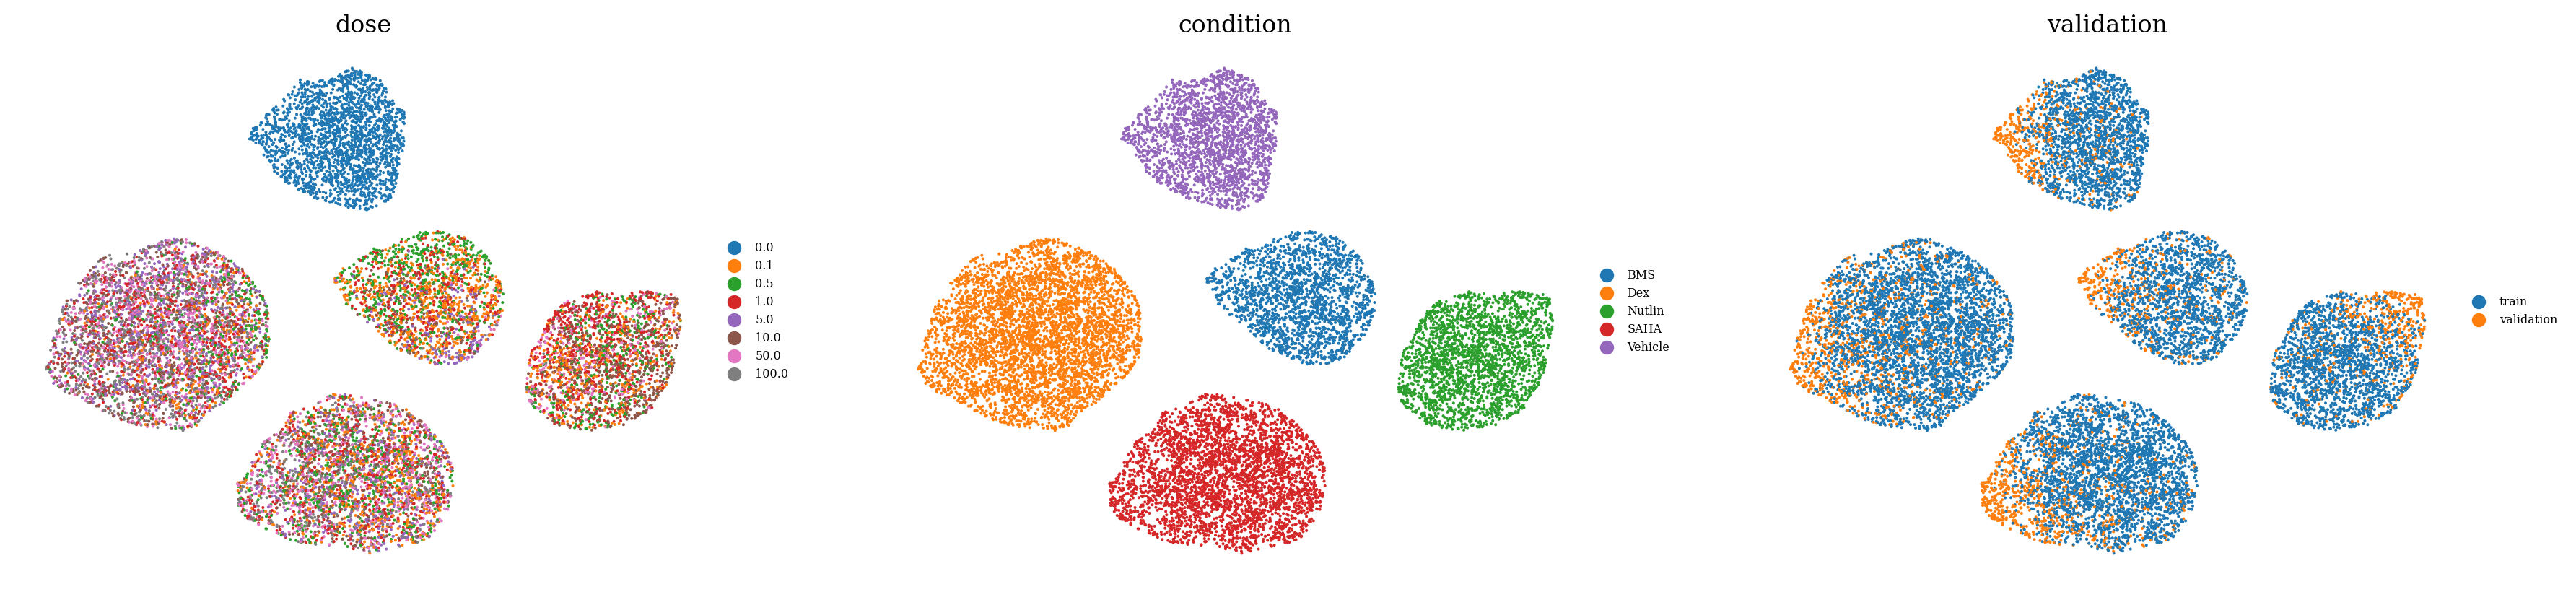

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )